In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [2]:
train_data = pd.read_csv('datas/train.csv')
test_data=pd.read_csv('datas/test.csv')

In [3]:
print(train_data['User'].nunique())
print(test_data['User'].nunique())

1509
1519


In [4]:
train_data.head(5)

# Zipcode 값의 개수를 계산
zipcode_counts = train_data['Zipcode'].value_counts()

# DataFrame으로 변환
zipcode_counts_df = zipcode_counts.reset_index()
zipcode_counts_df.columns = ['Zipcode', 'Count']

# CSV 파일로 저장
zipcode_counts_df.to_csv('zipcode_counts.csv', index=False)

In [5]:
train_data.columns

Index(['User', 'Gender', 'Current Age', 'Retirement Age', 'Birth Year',
       'Birth Month', 'Zipcode', 'Per Capita Income - Zipcode',
       'Yearly Income', 'Total Debt', 'Credit Score', 'Year', 'Month', 'Day',
       'Merchandise Code', 'Card', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'Has Chip', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'Amount', 'Whether Security Chip is Used',
       'Error Message', 'Is Fraud?'],
      dtype='object')

#### 전처리 : 10.13 회의에서 언급된대로

### EDA 시작

In [6]:
train_data.isna().sum()

User                                   0
Gender                                 0
Current Age                            0
Retirement Age                         0
Birth Year                             0
Birth Month                            0
Zipcode                                0
Per Capita Income - Zipcode            0
Yearly Income                          0
Total Debt                             0
Credit Score                           0
Year                                   0
Month                                  0
Day                                    0
Merchandise Code                       0
Card                                   0
Card Brand                             0
Card Type                              0
Card Number                            0
Expires                                0
Has Chip                               0
Credit Limit                           0
Acct Open Date                         0
Year PIN last Changed                  0
Amount          

In [7]:
#라벨링 잔뜩
def encode_and_transform_dates(df):
    # 1. 라벨 인코딩할 열들 지정
    label_cols = ['Card Brand', 'Card Type', 'Error Message', 'Is Fraud?']
    
    # 2. 각 열에 대해 라벨 인코딩 수행
    label_encoders = {}
    for col in label_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 나중에 필요하면 인코더 저장 (복원할 때 사용 가능)
    
    # 3. 날짜 데이터를 8자리 숫자로 변환
    # 'Expires' 변환 (MM/YYYY -> YYYYMMDD)
    df['Expires'] = df['Expires'].apply(lambda x: x.split('/')[1] + x.split('/')[0] + '01')
    
    # 'Acct Open Date' 변환 (MM/YYYY -> YYYYMMDD)
    df['Acct Open Date'] = df['Acct Open Date'].apply(lambda x: x.split('/')[1] + x.split('/')[0] + '01')
    
    # 날짜 형식을 int 타입으로 변환
    df['Expires'] = df['Expires'].astype(int)
    df['Acct Open Date'] = df['Acct Open Date'].astype(int)
    
    # 인코딩된 데이터프레임 반환
    return df

train_data = encode_and_transform_dates(train_data)

#Is Fraud : Yes-1, No-0으로 Labeled


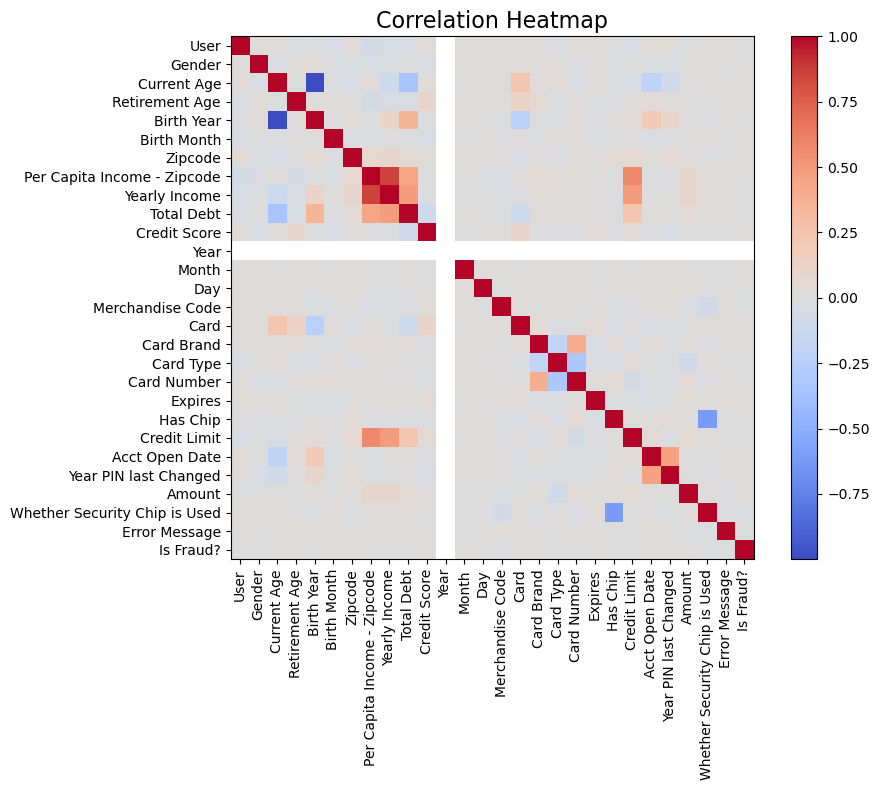

In [8]:
def correlation_write(df,path='datas/파생/correlation_matrix.csv',columns=28):
    # 상관관계 계산
    correlation_matrix = df.corr()
    # 상관관계 결과를 CSV로 저장
    correlation_matrix.to_csv(path)
    # 히트맵 그리기
    plt.figure(figsize=(10, 8)) 
    plt.title("Correlation Heatmap", fontsize=16)
    heatmap = plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
    plt.colorbar(heatmap)
    plt.xticks(np.arange(columns), labels=correlation_matrix.columns, rotation=90)
    plt.yticks(np.arange(columns), labels=correlation_matrix.columns)

    plt.tight_layout()
    plt.show()
correlation_write(train_data)

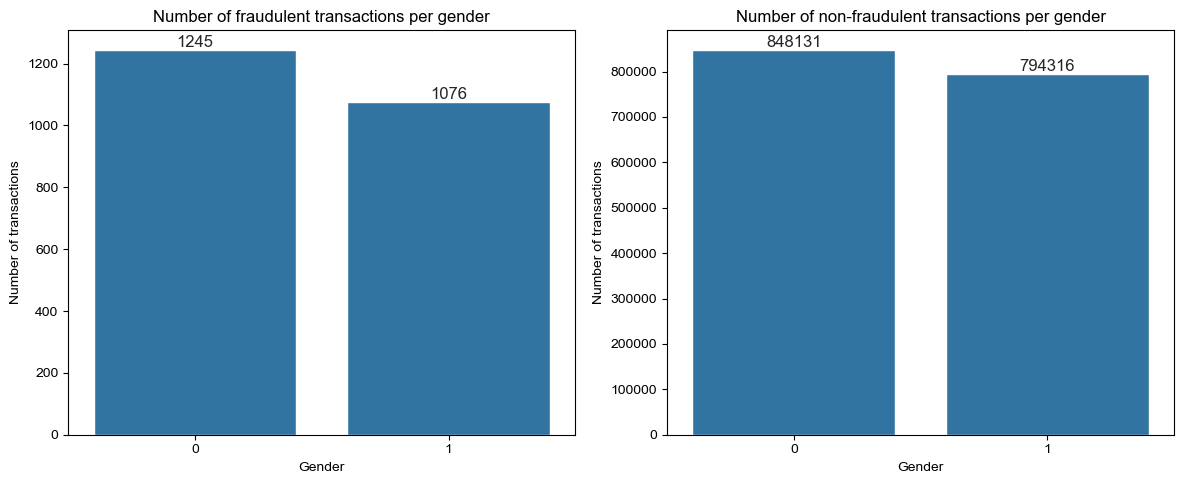

In [9]:
# Dividing train dataset into 2 sections - fraudulent and non-fraudulent

fraud = train_data[train_data['Is Fraud?'] == 1]
not_fraud = train_data[train_data['Is Fraud?'] == 0]
# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_theme()

# Getting the counts of fraudulent and non-fraudulent activities per gender
g_fraud = fraud['Gender'].value_counts().reset_index()
g_fraud.columns = ["Gender", "Counts"]
g_not_fraud = not_fraud['Gender'].value_counts().reset_index()
g_not_fraud.columns = ["Gender", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per gender
sns.barplot(x="Gender", y="Counts", data=g_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Gender", y="Counts", data=g_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()

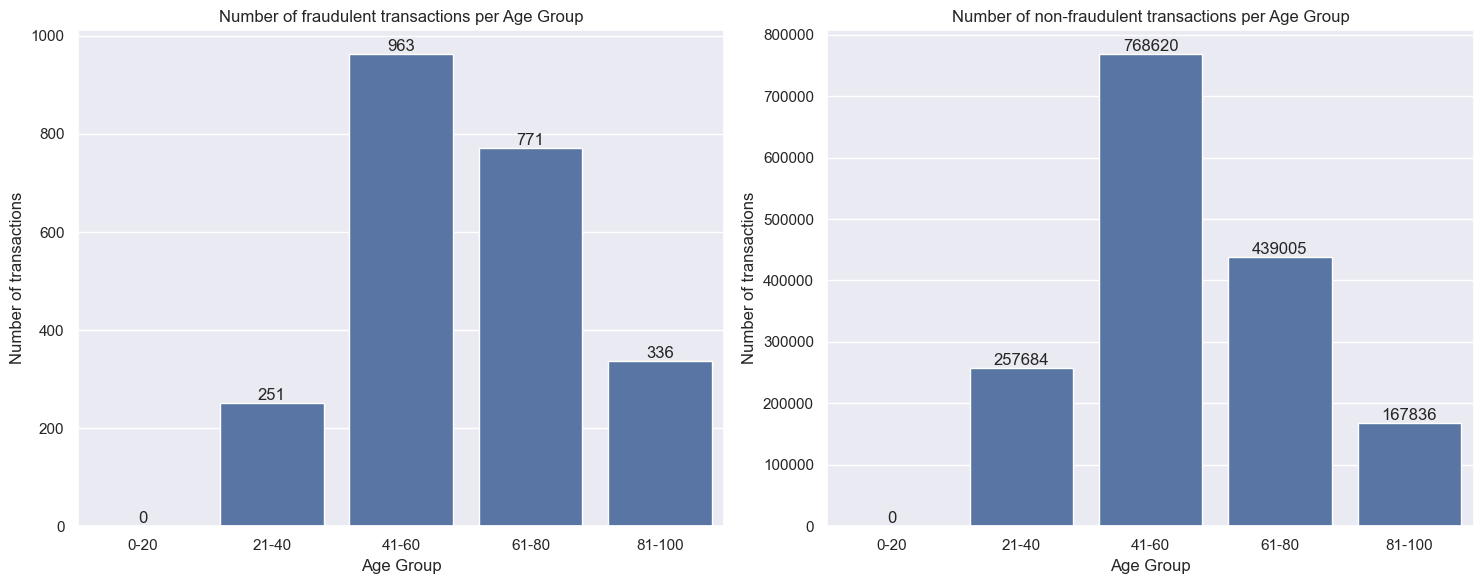

In [10]:
# 현재 연도 기준으로 나이를 계산합니다.
current_year = pd.Timestamp.now().year
train_data['Age'] = current_year - train_data['Birth Year']

# 나이를 기준으로 데이터를 5개의 그룹으로 나눕니다.
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
train_data['Age Group'] = pd.cut(train_data['Age'], bins=bins, labels=labels)

# 각 그룹별로 사기와 비사기 데이터 나누기
fraud = train_data[train_data['Is Fraud?'] == 1]
not_fraud = train_data[train_data['Is Fraud?'] == 0]

# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.set_theme()

# 각 그룹별 사기 거래 수와 비사기 거래 수 계산
g_fraud = fraud['Age Group'].value_counts().reset_index()
g_fraud.columns = ["Age Group", "Counts"]
g_not_fraud = not_fraud['Age Group'].value_counts().reset_index()
g_not_fraud.columns = ["Age Group", "Counts"]

# Plotting the number of fraudulent and non-fraudulent transactions per Age Group
sns.barplot(x="Age Group", y="Counts", data=g_fraud, ax=axes[0])
axes[0].set_title("Number of fraudulent transactions per Age Group")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Number of transactions")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x="Age Group", y="Counts", data=g_not_fraud, ax=axes[1])
axes[1].set_title("Number of non-fraudulent transactions per Age Group")
axes[1].set_xlabel("Age Group")
axes[1].set_ylabel("Number of transactions")
axes[1].bar_label(axes[1].containers[0])

plt.tight_layout()
plt.show()

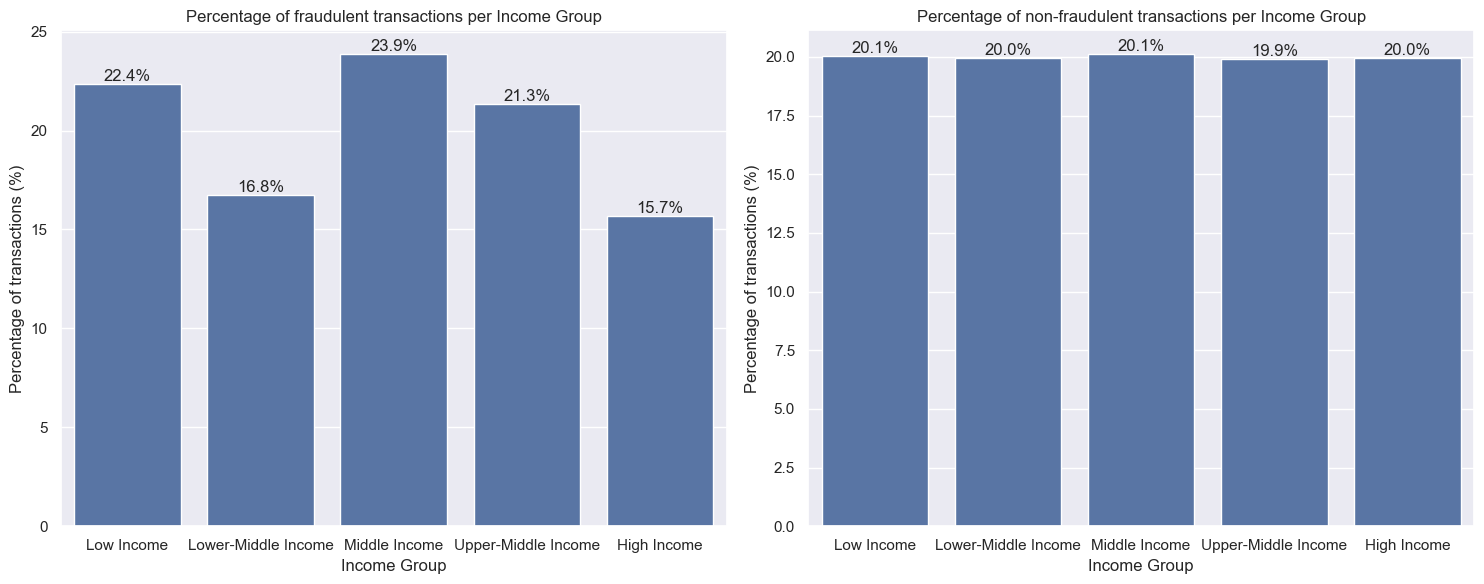

In [11]:
# 'Yearly Income' 기준으로 데이터를 5개의 동일한 비율로 그룹으로 나눕니다.
labels = ['Low Income', 'Lower-Middle Income', 'Middle Income', 'Upper-Middle Income', 'High Income']
train_data['Income Group'] = pd.qcut(train_data['Yearly Income'], q=5, labels=labels)

# 각 그룹별로 사기와 비사기 데이터 나누기
fraud = train_data[train_data['Is Fraud?'] == 1]
not_fraud = train_data[train_data['Is Fraud?'] == 0]

# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.set_theme()

# 각 그룹별 사기 거래 수와 비사기 거래 수 계산
g_fraud = fraud['Income Group'].value_counts(normalize=True).reset_index()
g_fraud.columns = ["Income Group", "Percentage"]
g_fraud['Percentage'] *= 100
g_not_fraud = not_fraud['Income Group'].value_counts(normalize=True).reset_index()
g_not_fraud.columns = ["Income Group", "Percentage"]
g_not_fraud['Percentage'] *= 100

# Plotting the percentage of fraudulent and non-fraudulent transactions per Income Group
sns.barplot(x="Income Group", y="Percentage", data=g_fraud, ax=axes[0])
axes[0].set_title("Percentage of fraudulent transactions per Income Group")
axes[0].set_xlabel("Income Group")
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].bar_label(axes[0].containers[0], fmt='%.1f%%')

sns.barplot(x="Income Group", y="Percentage", data=g_not_fraud, ax=axes[1])
axes[1].set_title("Percentage of non-fraudulent transactions per Income Group")
axes[1].set_xlabel("Income Group")
axes[1].set_ylabel("Percentage of transactions (%)")
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%')

plt.tight_layout()
plt.show()

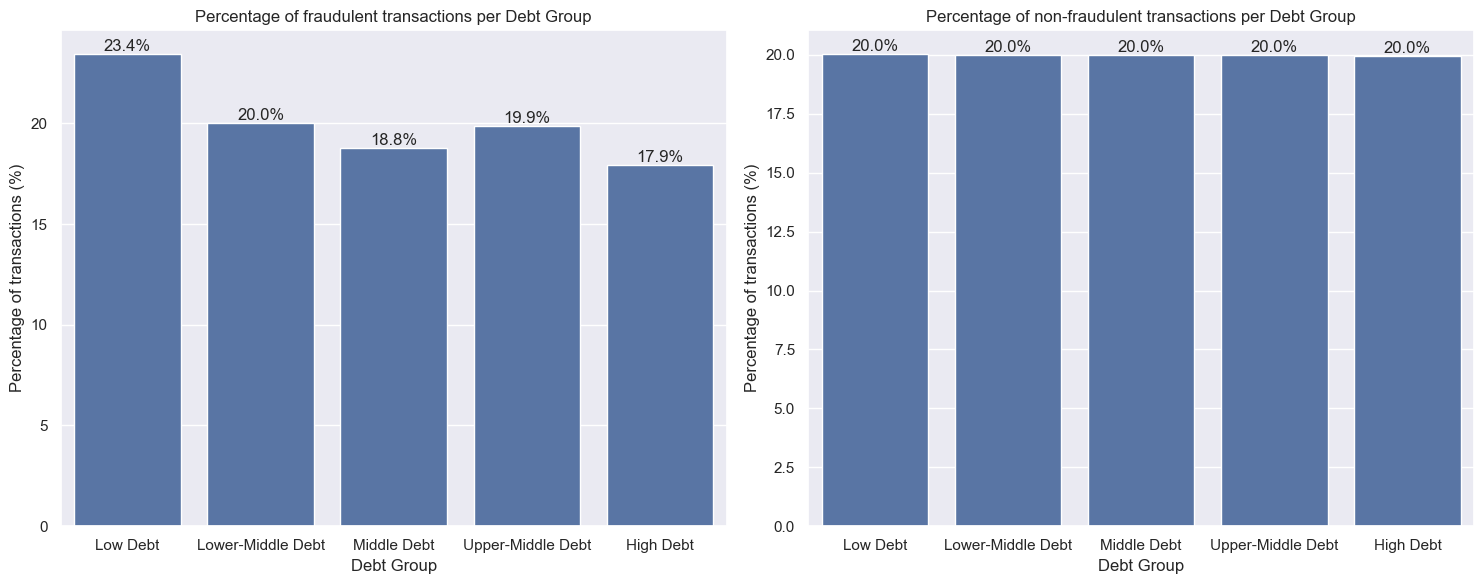

In [12]:
# 'Total Debt' 기준으로 데이터를 5개의 동일한 비율로 그룹으로 나눕니다.
debt_labels = ['Low Debt', 'Lower-Middle Debt', 'Middle Debt', 'Upper-Middle Debt', 'High Debt']
train_data['Debt Group'] = pd.qcut(train_data['Total Debt'], q=5, labels=debt_labels)

# 각 그룹별로 사기와 비사기 데이터 나누기
fraud = train_data[train_data['Is Fraud?'] == 1]
not_fraud = train_data[train_data['Is Fraud?'] == 0]

# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.set_theme()

# 각 그룹별 사기 거래 수와 비사기 거래 수 계산 (Total Debt)
g_fraud_debt = fraud['Debt Group'].value_counts(normalize=True).reset_index()
g_fraud_debt.columns = ["Debt Group", "Percentage"]
g_fraud_debt['Percentage'] *= 100
g_not_fraud_debt = not_fraud['Debt Group'].value_counts(normalize=True).reset_index()
g_not_fraud_debt.columns = ["Debt Group", "Percentage"]
g_not_fraud_debt['Percentage'] *= 100

# Plotting the percentage of fraudulent and non-fraudulent transactions per Debt Group
sns.barplot(x="Debt Group", y="Percentage", data=g_fraud_debt, ax=axes[0])
axes[0].set_title("Percentage of fraudulent transactions per Debt Group")
axes[0].set_xlabel("Debt Group")
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].bar_label(axes[0].containers[0], fmt='%.1f%%')

sns.barplot(x="Debt Group", y="Percentage", data=g_not_fraud_debt, ax=axes[1])
axes[1].set_title("Percentage of non-fraudulent transactions per Debt Group")
axes[1].set_xlabel("Debt Group")
axes[1].set_ylabel("Percentage of transactions (%)")
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%')

plt.tight_layout()
plt.show()

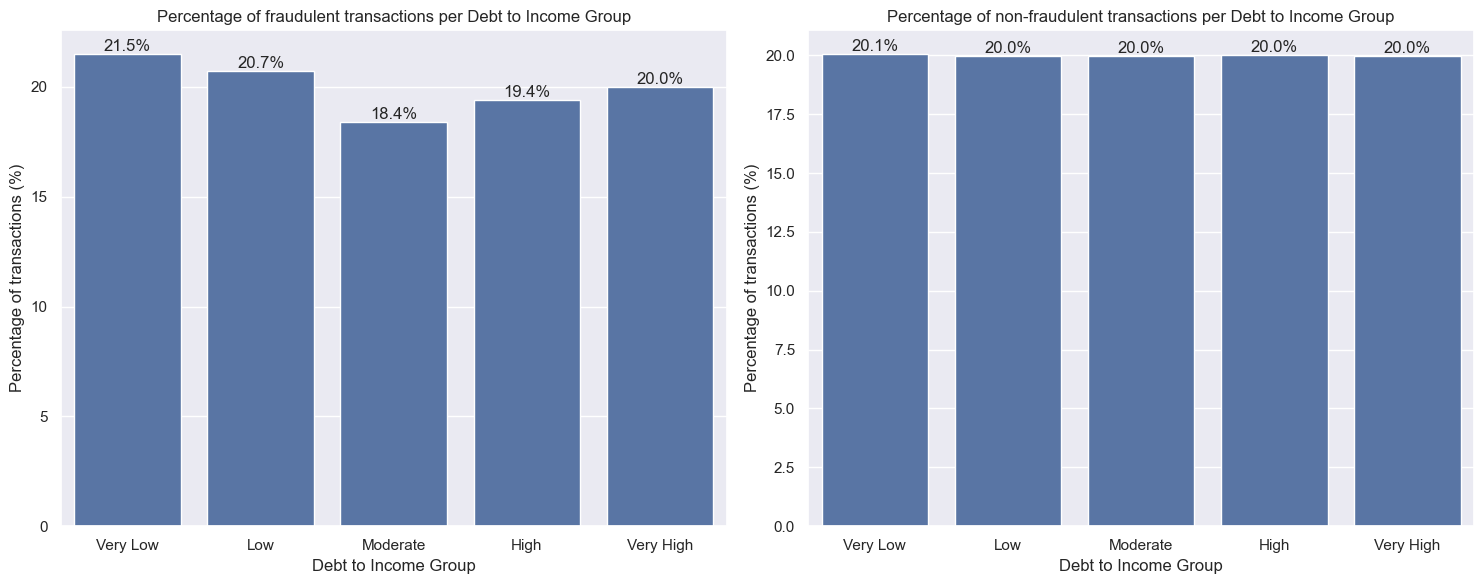

In [13]:
# 'Total Debt'와 'Yearly Income'을 사용하여 부채 대비 소득 비율을 계산합니다.
train_data['Debt to Income Ratio'] = train_data['Total Debt'] / train_data['Yearly Income']

# 부채 대비 소득 비율을 기준으로 데이터를 5개의 동일한 비율로 그룹으로 나눕니다.
dti_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
train_data['Debt to Income Group'] = pd.qcut(train_data['Debt to Income Ratio'], q=5, labels=dti_labels)

# 각 그룹별로 사기와 비사기 데이터 나누기
fraud = train_data[train_data['Is Fraud?'] == 1]
not_fraud = train_data[train_data['Is Fraud?'] == 0]

# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.set_theme()

# 각 그룹별 사기 거래 수와 비사기 거래 수 계산 (Debt to Income Ratio)
g_fraud_dti = fraud['Debt to Income Group'].value_counts(normalize=True).reset_index()
g_fraud_dti.columns = ["Debt to Income Group", "Percentage"]
g_fraud_dti['Percentage'] *= 100
g_not_fraud_dti = not_fraud['Debt to Income Group'].value_counts(normalize=True).reset_index()
g_not_fraud_dti.columns = ["Debt to Income Group", "Percentage"]
g_not_fraud_dti['Percentage'] *= 100

# Plotting the percentage of fraudulent and non-fraudulent transactions per Debt to Income Group
sns.barplot(x="Debt to Income Group", y="Percentage", data=g_fraud_dti, ax=axes[0])
axes[0].set_title("Percentage of fraudulent transactions per Debt to Income Group")
axes[0].set_xlabel("Debt to Income Group")
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].bar_label(axes[0].containers[0], fmt='%.1f%%')

sns.barplot(x="Debt to Income Group", y="Percentage", data=g_not_fraud_dti, ax=axes[1])
axes[1].set_title("Percentage of non-fraudulent transactions per Debt to Income Group")
axes[1].set_xlabel("Debt to Income Group")
axes[1].set_ylabel("Percentage of transactions (%)")
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%')

plt.tight_layout()
plt.show()

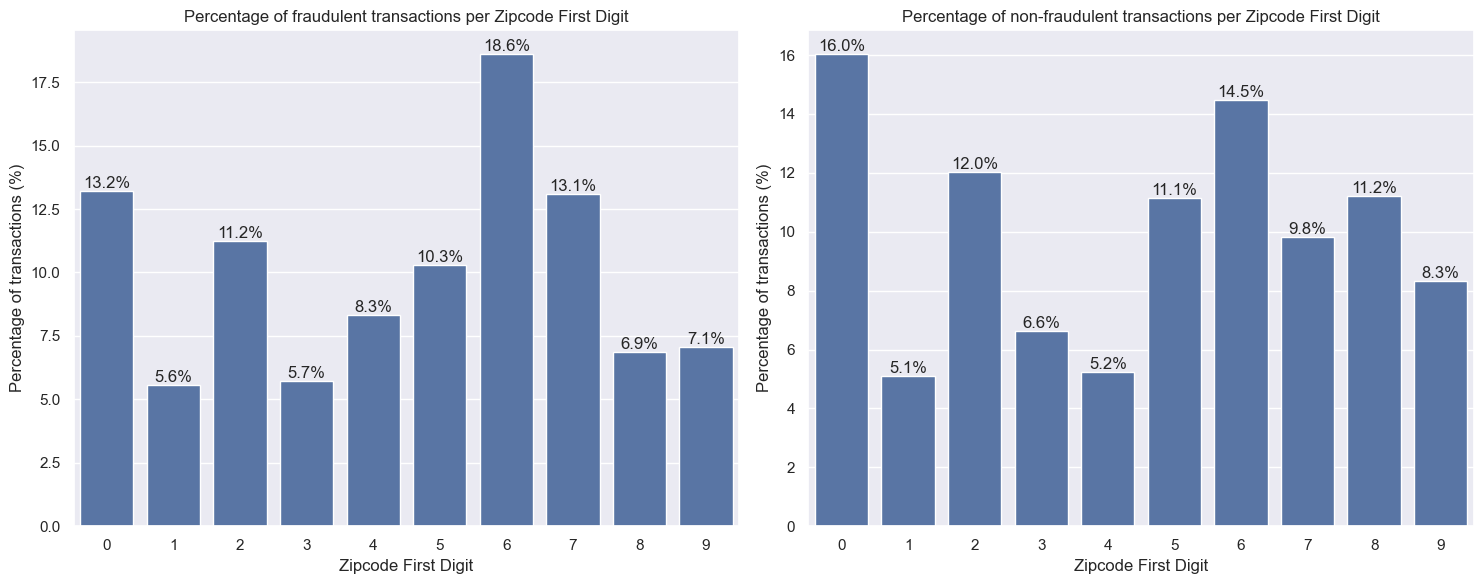

In [14]:
# 주소를 기준으로 데이터를 5개의 그룹으로 나눕니다.
bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000]
labels = ['0','1','2','3','4','5','6','7','8','9']
train_data['Zipcode First Digit'] = pd.cut(train_data['Zipcode'], bins=bins, labels=labels)

# 각 그룹별로 사기와 비사기 데이터 나누기
fraud = train_data[train_data['Is Fraud?'] == 1]
not_fraud = train_data[train_data['Is Fraud?'] == 0]

# Creating a 1x2 grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.set_theme()

# 각 그룹별 사기 거래 수와 비사기 거래 수 계산 (Zipcode First Digit)
g_fraud_zip_first = fraud['Zipcode First Digit'].value_counts(normalize=True).reset_index()
g_fraud_zip_first.columns = ["Zipcode First Digit", "Percentage"]
g_fraud_zip_first['Percentage'] *= 100
g_not_fraud_zip_first = not_fraud['Zipcode First Digit'].value_counts(normalize=True).reset_index()
g_not_fraud_zip_first.columns = ["Zipcode First Digit", "Percentage"]
g_not_fraud_zip_first['Percentage'] *= 100

# Plotting the percentage of fraudulent and non-fraudulent transactions per Zipcode First Digit
sns.barplot(x="Zipcode First Digit", y="Percentage", data=g_fraud_zip_first, ax=axes[0])
axes[0].set_title("Percentage of fraudulent transactions per Zipcode First Digit")
axes[0].set_xlabel("Zipcode First Digit")
axes[0].set_ylabel("Percentage of transactions (%)")
axes[0].bar_label(axes[0].containers[0], fmt='%.1f%%')

sns.barplot(x="Zipcode First Digit", y="Percentage", data=g_not_fraud_zip_first, ax=axes[1])
axes[1].set_title("Percentage of non-fraudulent transactions per Zipcode First Digit")
axes[1].set_xlabel("Zipcode First Digit")
axes[1].set_ylabel("Percentage of transactions (%)")
axes[1].bar_label(axes[1].containers[0], fmt='%.1f%%')

plt.tight_layout()
plt.show()


In [15]:
train_data.head()

,User,Gender,Current Age,Retirement Age,Birth Year,Birth Month,Zipcode,Per Capita Income - Zipcode,Yearly Income,Total Debt,...,Whether Security Chip is Used,Error Message,Is Fraud?,Age,Age Group,Income Group,Debt Group,Debt to Income Ratio,Debt to Income Group,Zipcode First Digit
0,0,0,53,66,1966,11,8250.0,17420410,52077100.0,9.088794e+07,...,0,18,0,58,41-60,High Income,High Debt,1.745257,High,0
1,0,0,53,66,1966,11,8250.0,17420410,52077100.0,9.088794e+07,...,0,18,0,58,41-60,High Income,High Debt,1.745257,High,0
2,0,0,53,66,1966,11,8250.0,17420410,52077100.0,9.088794e+07,...,1,18,0,58,41-60,High Income,High Debt,1.745257,High,0
3,0,0,53,66,1966,11,8250.0,17420410,52077100.0,9.088794e+07,...,0,18,0,58,41-60,High Income,High Debt,1.745257,High,0
4,0,0,53,66,1966,11,8250.0,17420410,52077100.0,9.088794e+07,...,0,18,0,58,41-60,High Income,High Debt,1.745257,High,0


---
---
---
#### User 기반 분석

In [16]:
train_data = pd.read_csv('datas/train.csv')
train_data = encode_and_transform_dates(train_data)

In [17]:
# 1. User와 Is Fraud?별 Count와 Percentage를 계산한 g_user_fraud 생성
g_user_fraud = train_data.groupby(['User', 'Is Fraud?']).size().reset_index(name='Count')
g_user_fraud['Percentage'] = g_user_fraud.groupby('User')['Count'].transform(lambda x: x / x.sum() * 100)

# 2. 원래 train_data와 g_user_fraud를 User와 Is Fraud? 기준으로 병합
# train_data의 정보를 유지하면서, g_user_fraud에서 계산된 결과를 결합
merged_data = pd.merge(train_data, g_user_fraud, on=['User', 'Is Fraud?'], how='left')

# 3. CSV 파일로 저장
merged_data.to_csv('user_fraud_percentage_with_details.csv', index=False)


In [18]:
# Percentage가 100인 그룹
percentage_100 = merged_data[merged_data['Percentage'] == 100]

# Percentage가 100이 아닌 그룹
percentage_not_100 = merged_data[merged_data['Percentage'] != 100]

In [19]:
percentage_100.describe()


,User,Gender,Current Age,Retirement Age,Birth Year,Birth Month,Zipcode,Per Capita Income - Zipcode,Yearly Income,Total Debt,...,Expires,Credit Limit,Acct Open Date,Year PIN last Changed,Amount,Whether Security Chip is Used,Error Message,Is Fraud?,Count,Percentage
count,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,...,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1.391372e+06,1391372.0,1.391372e+06,1391372.0
mean,1.002262e+03,4.891359e-01,5.182482e+01,6.639968e+01,1.967366e+03,6.525552e+00,4.972502e+04,1.441683e+07,2.834605e+07,3.658637e+07,...,2.022003e+07,9.212645e+06,2.008380e+07,2.011792e+03,2.553998e+04,4.684412e-01,1.792732e+01,0.0,1.381516e+03,100.0
std,5.727526e+02,4.998821e-01,1.642072e+01,3.596333e+00,1.640934e+01,3.560269e+00,2.981091e+04,7.184263e+06,1.609811e+07,3.485446e+07,...,1.447442e+04,7.202748e+06,4.592961e+04,3.061298e+00,5.492671e+04,7.680090e-01,7.685071e-01,0.0,7.152973e+02,0.0
min,0.000000e+00,0.000000e+00,2.000000e+01,5.000000e+01,1.918000e+03,1.000000e+00,4.920000e+02,0.000000e+00,8.000000e+02,0.000000e+00,...,2.020010e+07,0.000000e+00,1.991010e+07,2.002000e+03,-7.408000e+05,0.000000e+00,0.000000e+00,0.0,2.000000e+00,100.0
25%,5.140000e+02,0.000000e+00,3.900000e+01,6.500000e+01,1.957000e+03,3.000000e+00,2.246100e+04,1.019949e+07,1.855700e+07,1.008795e+07,...,2.021010e+07,4.641000e+06,2.005110e+07,2.010000e+03,3.600000e+03,0.000000e+00,1.800000e+01,0.0,8.890000e+02,100.0
50%,9.920000e+02,0.000000e+00,5.000000e+01,6.600000e+01,1.970000e+03,7.000000e+00,5.387600e+04,1.279072e+07,2.481880e+07,3.127051e+07,...,2.022060e+07,8.008700e+06,2.008120e+07,2.011000e+03,1.410000e+04,0.000000e+00,1.800000e+01,0.0,1.213000e+03,100.0
75%,1.479000e+03,1.000000e+00,6.200000e+01,6.800000e+01,1.980000e+03,1.000000e+01,7.248000e+04,1.664394e+07,3.409720e+07,5.274752e+07,...,2.023090e+07,1.235518e+07,2.011070e+07,2.014000e+03,3.610000e+04,1.000000e+00,1.800000e+01,0.0,1.705000e+03,100.0
max,1.999000e+03,1.000000e+00,1.010000e+02,7.900000e+01,1.999000e+03,1.200000e+01,9.889300e+04,9.707128e+07,1.578132e+08,3.171627e+08,...,2.024120e+07,8.412764e+07,2.019060e+07,2.020000e+03,2.936700e+06,2.000000e+00,1.800000e+01,0.0,4.326000e+03,100.0


In [20]:
percentage_not_100.describe()

,User,Gender,Current Age,Retirement Age,Birth Year,Birth Month,Zipcode,Per Capita Income - Zipcode,Yearly Income,Total Debt,...,Expires,Credit Limit,Acct Open Date,Year PIN last Changed,Amount,Whether Security Chip is Used,Error Message,Is Fraud?,Count,Percentage
count,253396.000000,253396.000000,253396.000000,253396.000000,253396.000000,253396.000000,253396.000000,2.533960e+05,2.533960e+05,2.533960e+05,...,2.533960e+05,2.533960e+05,2.533960e+05,253396.000000,2.533960e+05,253396.000000,253396.000000,253396.000000,253396.000000,253396.000000
mean,1015.985051,0.453133,54.847152,66.208409,1964.299397,6.487952,50762.425910,1.333422e+07,2.560204e+07,3.431272e+07,...,2.022046e+07,8.875756e+06,2.008512e+07,2011.984175,2.430340e+04,0.441254,17.930090,0.009160,1331.120625,98.192615
std,551.210245,0.497800,14.856217,3.417788,14.867762,3.656997,28800.665196,5.075818e+06,1.161486e+07,2.929517e+07,...,1.396946e+04,6.549798e+06,4.536132e+04,2.999123,5.267099e+04,0.760238,0.732376,0.095267,757.486976,9.332897
min,2.000000,0.000000,25.000000,54.000000,1927.000000,1.000000,1555.000000,0.000000e+00,5.000000e+02,0.000000e+00,...,2.020010e+07,0.000000e+00,1.993040e+07,2002.000000,-6.706000e+05,0.000000,0.000000,0.000000,1.000000,0.060901
25%,546.000000,0.000000,44.000000,65.000000,1954.000000,3.000000,24449.000000,1.005610e+07,1.752340e+07,1.015067e+07,...,2.021030e+07,4.700500e+06,2.005090e+07,2010.000000,3.200000e+03,0.000000,18.000000,0.000000,880.000000,98.791946
50%,1129.000000,0.000000,53.000000,66.000000,1966.000000,6.000000,53797.000000,1.232245e+07,2.403750e+07,3.022883e+07,...,2.022070e+07,8.054515e+06,2.009050e+07,2011.000000,1.300000e+04,0.000000,18.000000,0.000000,1135.000000,99.197145
75%,1473.000000,1.000000,65.000000,68.000000,1975.000000,10.000000,71789.000000,1.533136e+07,3.272250e+07,4.989502e+07,...,2.023090e+07,1.177564e+07,2.011110e+07,2014.000000,3.470000e+04,1.000000,18.000000,0.000000,1527.000000,99.529915
max,1997.000000,1.000000,92.000000,75.000000,1994.000000,12.000000,98398.000000,3.699532e+07,8.140650e+07,1.441707e+08,...,2.024120e+07,4.579477e+07,2.018110e+07,2020.000000,1.597400e+06,2.000000,18.000000,1.000000,4915.000000,99.939099


In [21]:
train_data = pd.read_csv('datas/train.csv')
train_data = encode_and_transform_dates(train_data)

In [22]:
df = train_data.groupby('User')
df.size()

User
0       1190
1        555
2       2715
3        893
4        993
        ... 
1995    1136
1996     949
1997    1336
1998     758
1999    1656
Length: 1509, dtype: int64

In [23]:
df=df.mean()


In [24]:
print(df.columns)
fraud=df[df['Is Fraud?']!=0]
nonfraud=df[df['Is Fraud?']==0]

Index(['Gender', 'Current Age', 'Retirement Age', 'Birth Year', 'Birth Month',
       'Zipcode', 'Per Capita Income - Zipcode', 'Yearly Income', 'Total Debt',
       'Credit Score', 'Year', 'Month', 'Day', 'Merchandise Code', 'Card',
       'Card Brand', 'Card Type', 'Card Number', 'Expires', 'Has Chip',
       'Credit Limit', 'Acct Open Date', 'Year PIN last Changed', 'Amount',
       'Whether Security Chip is Used', 'Error Message', 'Is Fraud?'],
      dtype='object')


In [25]:
fraud.describe()

,Gender,Current Age,Retirement Age,Birth Year,Birth Month,Zipcode,Per Capita Income - Zipcode,Yearly Income,Total Debt,Credit Score,...,Card Number,Expires,Has Chip,Credit Limit,Acct Open Date,Year PIN last Changed,Amount,Whether Security Chip is Used,Error Message,Is Fraud?
count,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,2.330000e+02,2.330000e+02,2.330000e+02,233.000000,...,2.330000e+02,2.330000e+02,233.000000,2.330000e+02,2.330000e+02,233.000000,233.000000,233.000000,233.000000,233.000000
mean,0.467811,54.381974,66.309013,1964.772532,6.536481,49560.369099,1.314287e+07,2.528135e+07,3.520736e+07,717.463519,...,5.144800e+15,2.022080e+07,0.910727,8.644189e+06,2.008544e+07,2011.995428,24964.105181,0.434360,17.932456,0.010972
std,0.500037,15.441632,3.229545,15.457805,3.628159,28245.012541,4.954665e+06,1.131694e+07,3.004465e+07,97.477007,...,8.477192e+14,9.448840e+03,0.196386,5.321750e+06,3.299069e+04,1.991014,9222.428410,0.353614,0.032737,0.007586
min,0.000000,25.000000,54.000000,1927.000000,1.000000,1555.000000,0.000000e+00,5.000000e+02,0.000000e+00,433.000000,...,3.802399e+15,2.020010e+07,0.000000,0.000000e+00,2.000799e+07,2006.000000,5605.395683,0.020089,17.800305,0.000609
25%,0.000000,43.000000,65.000000,1955.000000,3.000000,24449.000000,9.938285e+06,1.752340e+07,1.131736e+07,659.000000,...,4.636864e+15,2.021406e+07,1.000000,5.072157e+06,2.006332e+07,2010.666040,18387.469287,0.185299,17.915556,0.006036
50%,0.000000,53.000000,66.000000,1967.000000,7.000000,53693.000000,1.224570e+07,2.311720e+07,2.989759e+07,724.000000,...,4.987913e+15,2.022050e+07,1.000000,7.895688e+06,2.008345e+07,2011.732648,24022.131148,0.324487,17.935484,0.009674
75%,1.000000,64.000000,68.000000,1976.000000,10.000000,71208.000000,1.532482e+07,3.088170e+07,5.207371e+07,768.000000,...,5.367455e+15,2.022757e+07,1.000000,1.078664e+07,2.010734e+07,2013.331284,29804.051565,0.577365,17.955605,0.013850
max,1.000000,92.000000,75.000000,1994.000000,12.000000,98398.000000,3.699532e+07,8.140650e+07,1.441707e+08,979.000000,...,9.688905e+15,2.024120e+07,1.000000,4.039851e+07,2.017100e+07,2017.000000,52359.786325,1.962010,17.991131,0.067093


In [26]:
nonfraud.describe()

,Gender,Current Age,Retirement Age,Birth Year,Birth Month,Zipcode,Per Capita Income - Zipcode,Yearly Income,Total Debt,Credit Score,...,Card Number,Expires,Has Chip,Credit Limit,Acct Open Date,Year PIN last Changed,Amount,Whether Security Chip is Used,Error Message,Is Fraud?
count,1276.000000,1276.000000,1276.000000,1276.00000,1276.000000,1276.000000,1.276000e+03,1.276000e+03,1.276000e+03,1276.000000,...,1.276000e+03,1.276000e+03,1276.000000,1.276000e+03,1.276000e+03,1276.000000,1276.000000,1276.000000,1276.000000,1276.0
mean,0.491379,51.008621,66.418495,1968.18652,6.452194,49571.122257,1.382968e+07,2.722496e+07,3.582146e+07,711.387931,...,5.159046e+15,2.022005e+07,0.896686,8.661934e+06,2.008484e+07,2011.801951,26234.392375,0.465758,17.930468,0.0
std,0.500122,16.183722,3.593952,16.17288,3.537151,29393.637278,6.961405e+06,1.523827e+07,3.314258e+07,98.833641,...,9.772736e+14,1.104937e+04,0.236264,5.985866e+06,3.659597e+04,2.438631,15910.166288,0.407328,0.039337,0.0
min,0.000000,20.000000,50.000000,1918.00000,1.000000,492.000000,0.000000e+00,8.000000e+02,0.000000e+00,403.000000,...,3.005502e+15,2.020010e+07,0.000000,0.000000e+00,1.996050e+07,2003.000000,2987.312415,0.026738,17.516258,0.0
25%,0.000000,39.000000,65.000000,1958.00000,3.000000,22937.500000,1.000448e+07,1.794150e+07,1.113659e+07,643.000000,...,4.596625e+15,2.021110e+07,1.000000,4.882260e+06,2.006076e+07,2010.097033,18919.713919,0.189775,17.912433,0.0
50%,0.000000,49.000000,66.000000,1970.00000,7.000000,53763.500000,1.210170e+07,2.407330e+07,3.113315e+07,711.000000,...,4.949970e+15,2.022050e+07,1.000000,7.669632e+06,2.008384e+07,2011.547623,24365.253450,0.332421,17.938721,0.0
75%,1.000000,61.000000,69.000000,1980.00000,10.000000,71785.750000,1.572987e+07,3.263538e+07,5.111675e+07,780.000000,...,5.425699e+15,2.022806e+07,1.000000,1.117443e+07,2.010586e+07,2013.253559,31137.946429,0.601620,17.955360,0.0
max,1.000000,101.000000,79.000000,1999.00000,12.000000,98893.000000,9.707128e+07,1.578132e+08,3.171627e+08,1057.000000,...,9.696612e+15,2.024120e+07,1.000000,6.295525e+07,2.019010e+07,2020.000000,461700.000000,1.994104,18.000000,0.0


C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


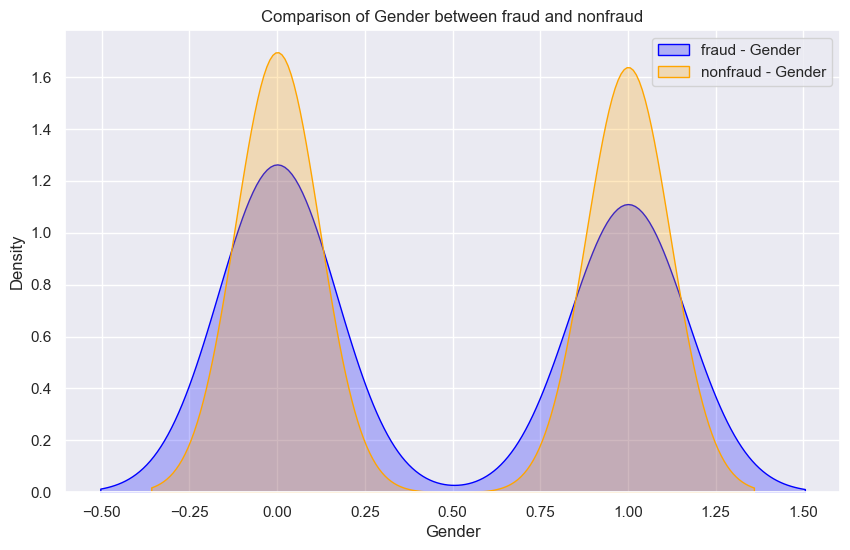

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


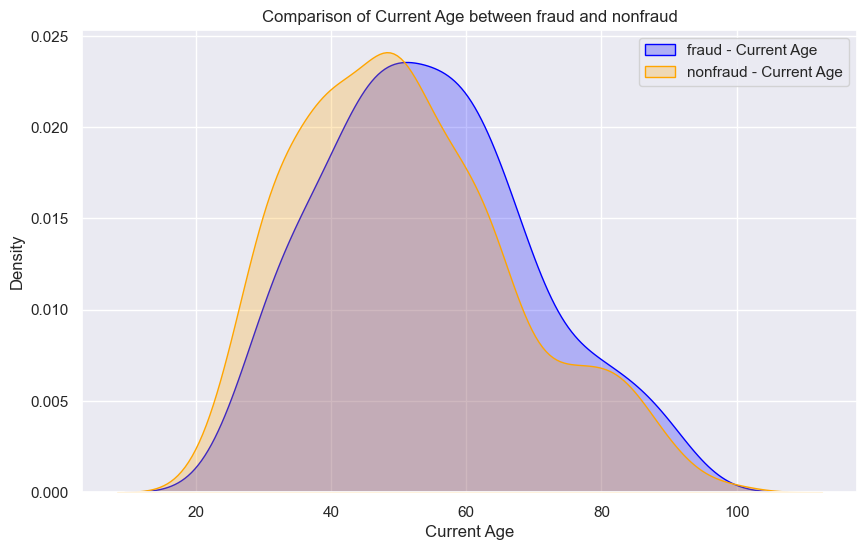

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


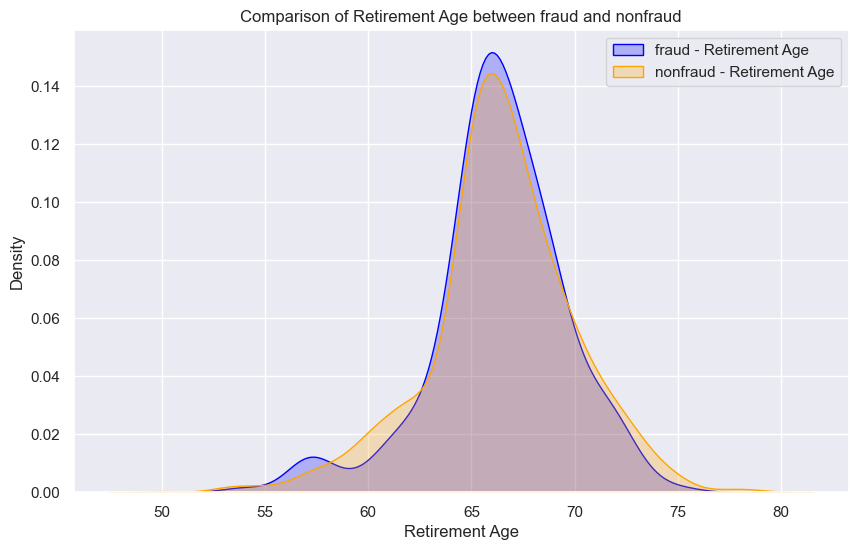

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


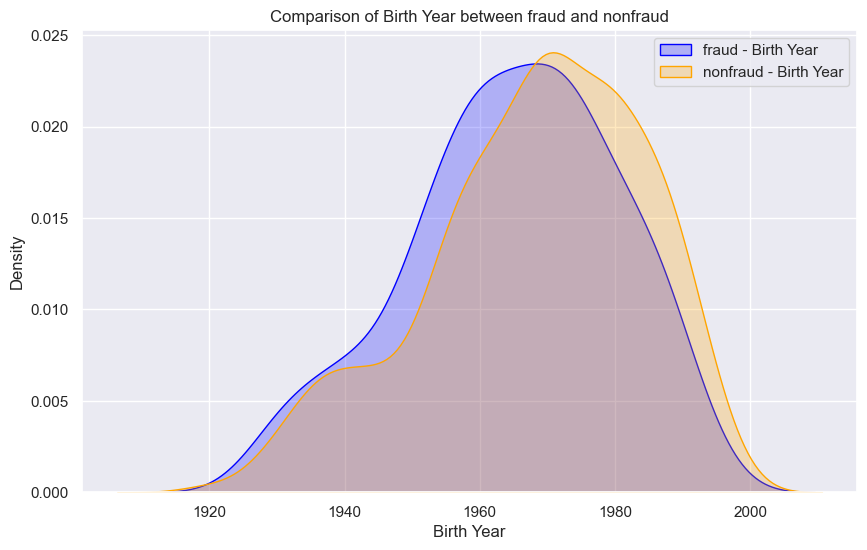

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


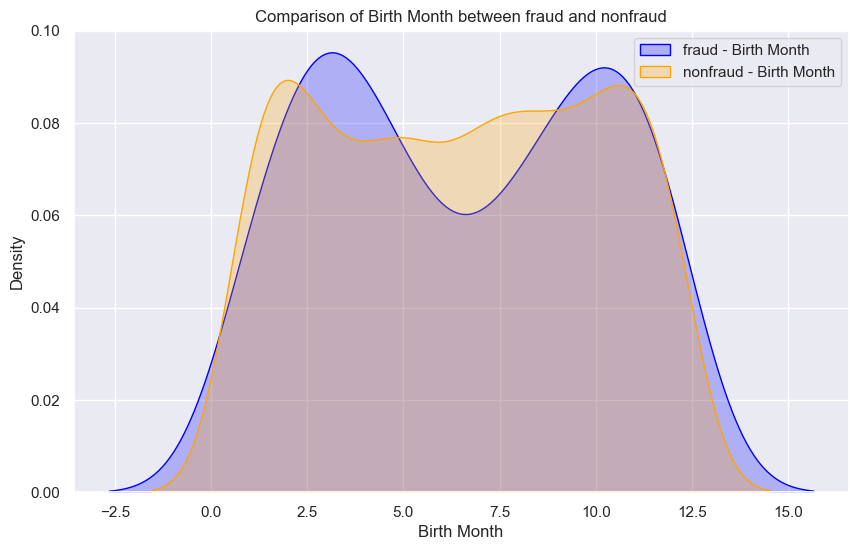

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


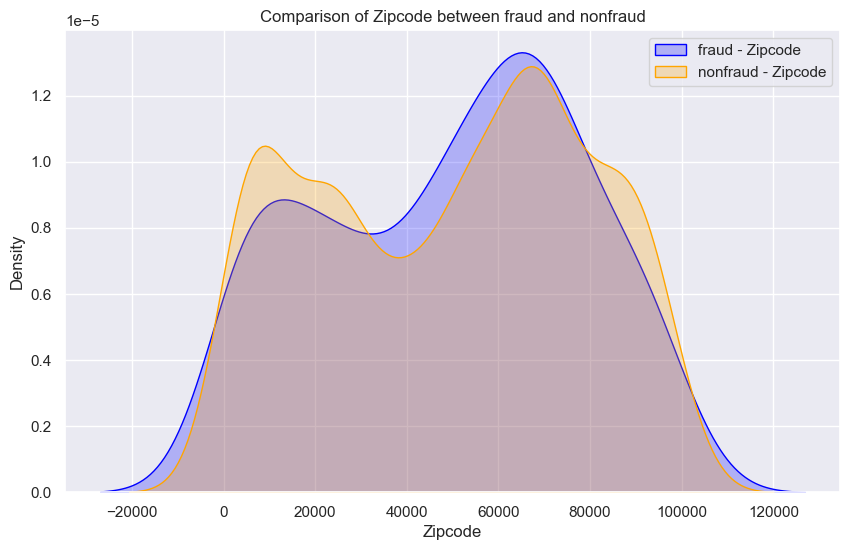

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


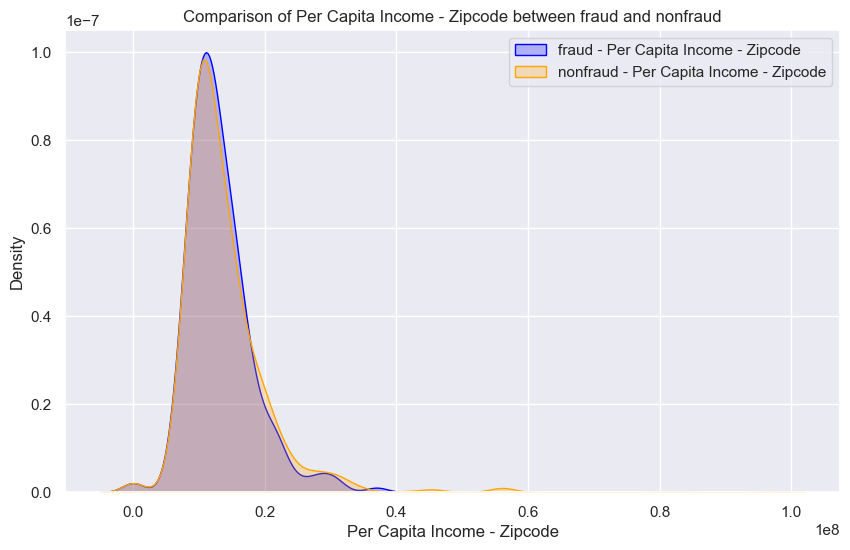

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


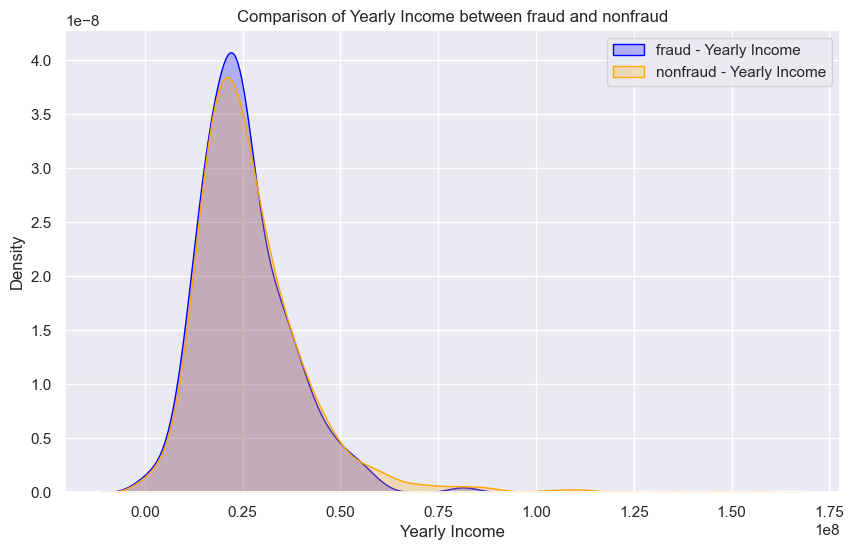

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


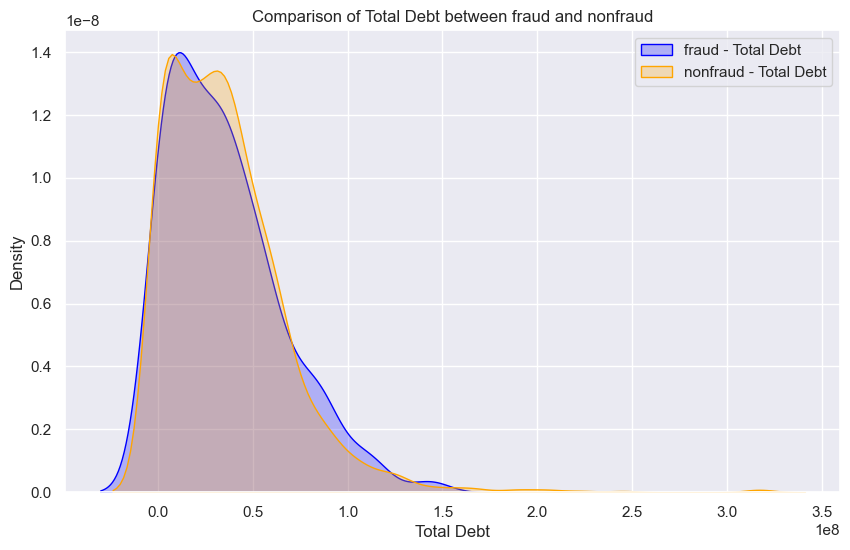

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


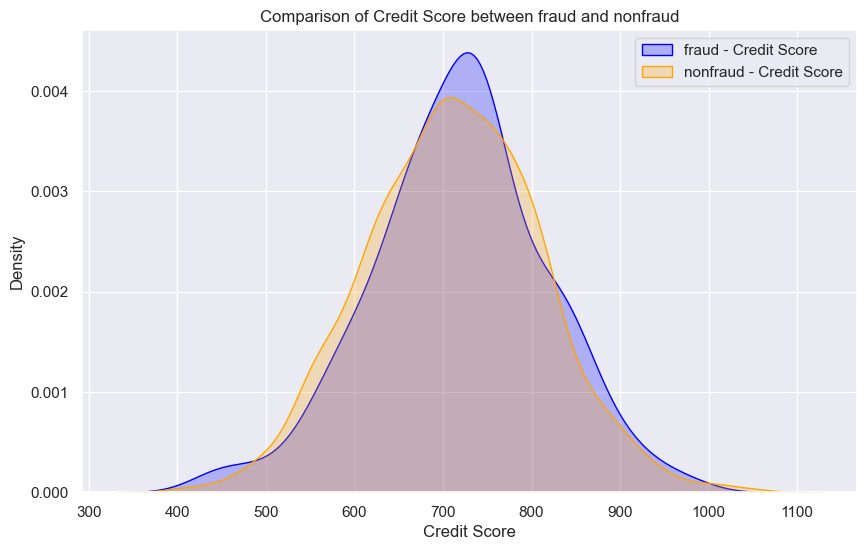

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: UserWarning: Dataset has 0 variance; skipping densit

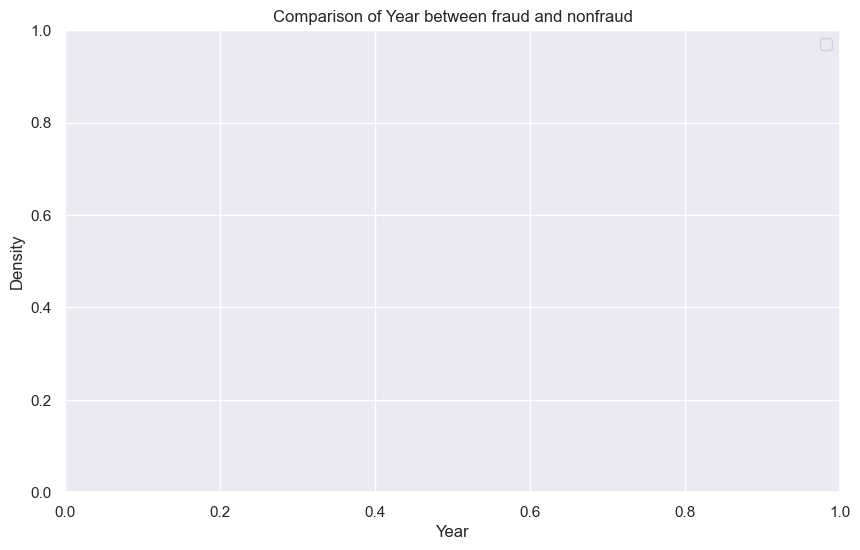

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


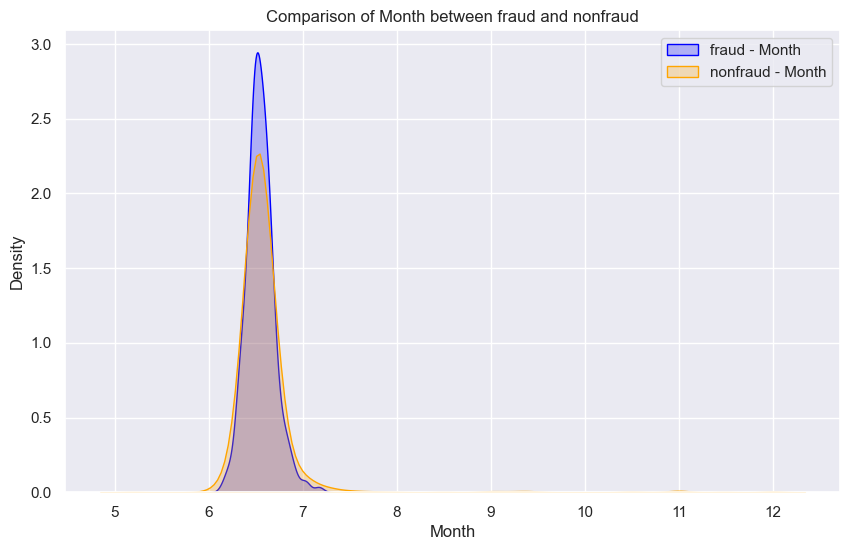

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


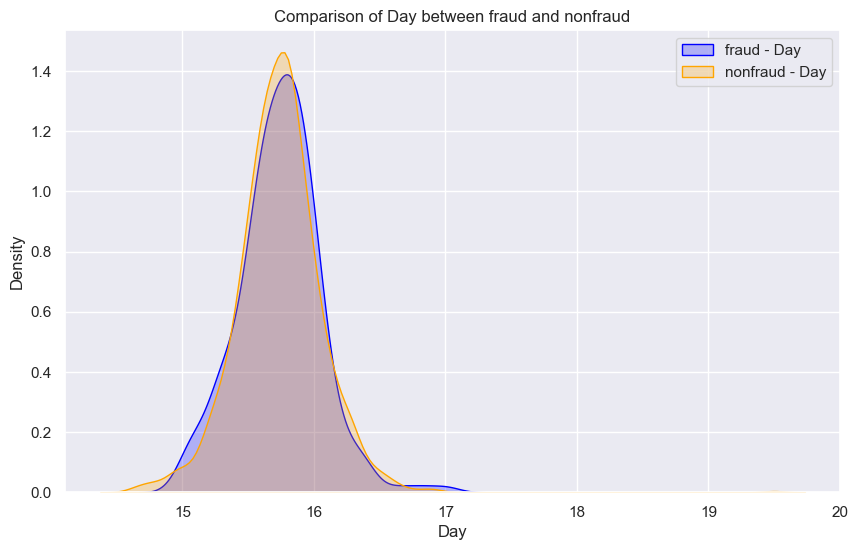

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


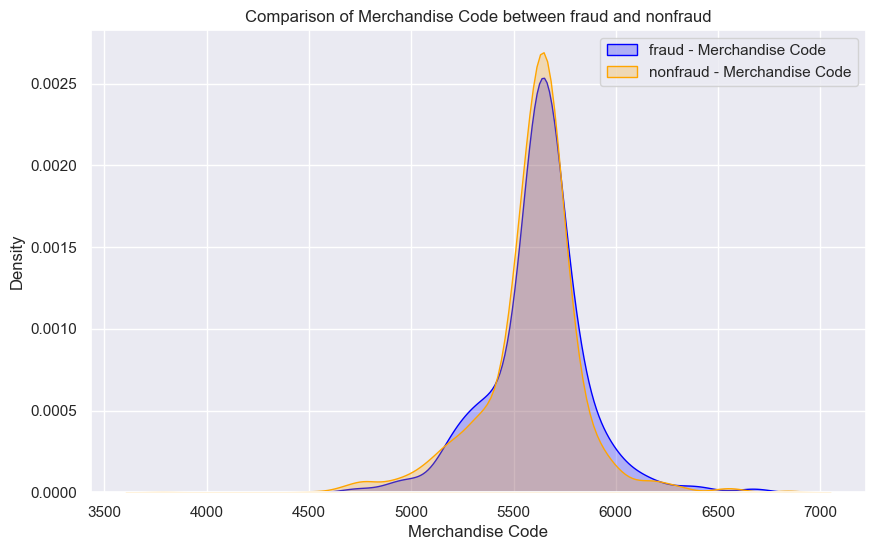

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


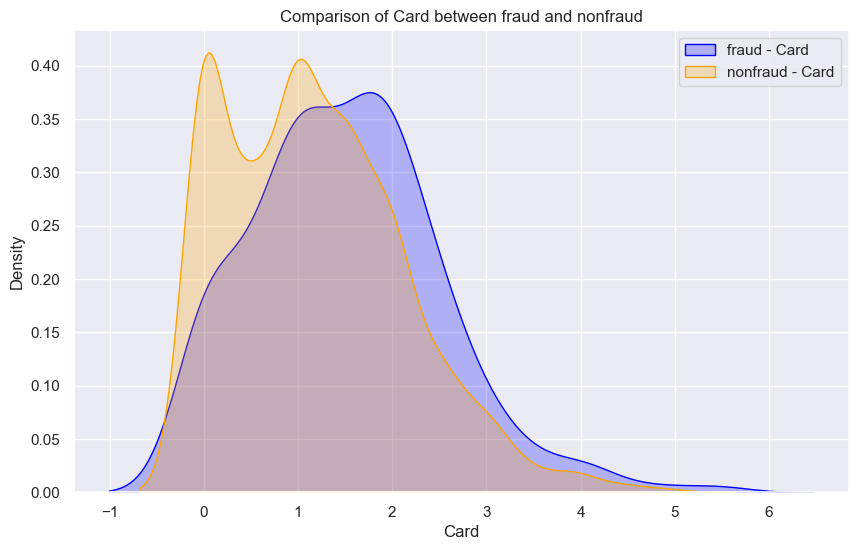

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


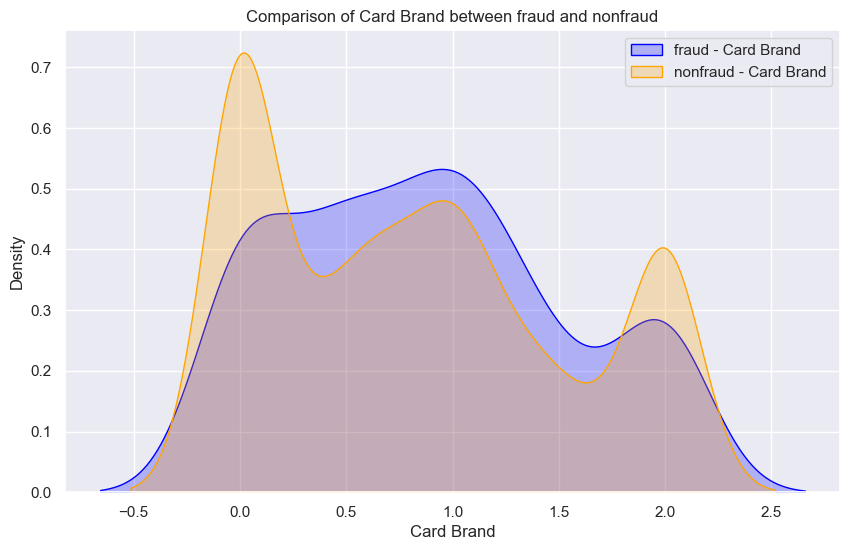

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


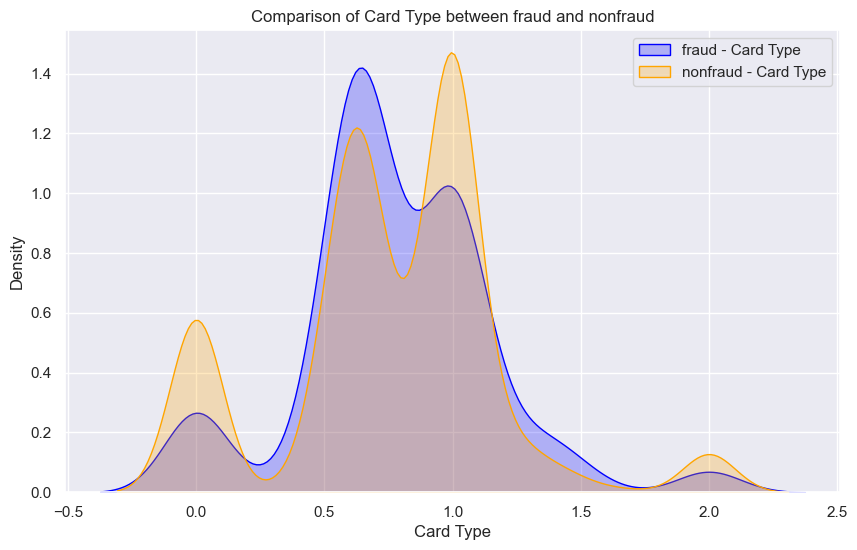

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


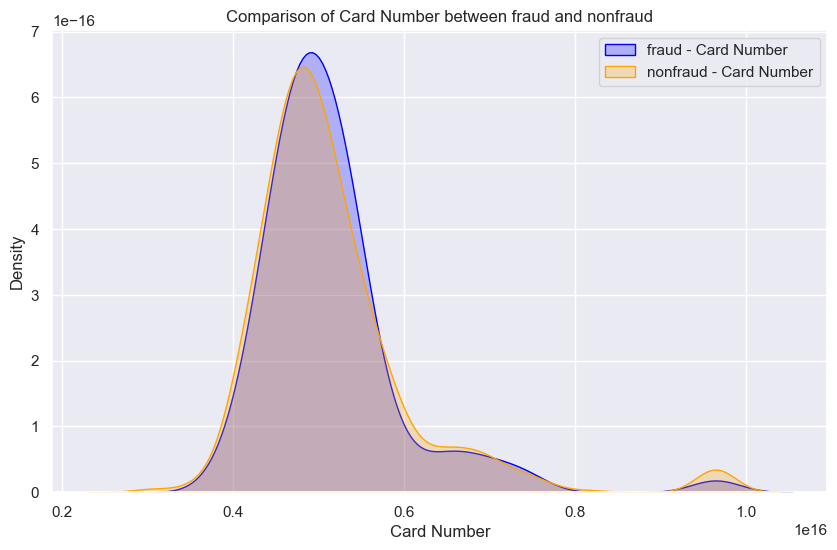

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


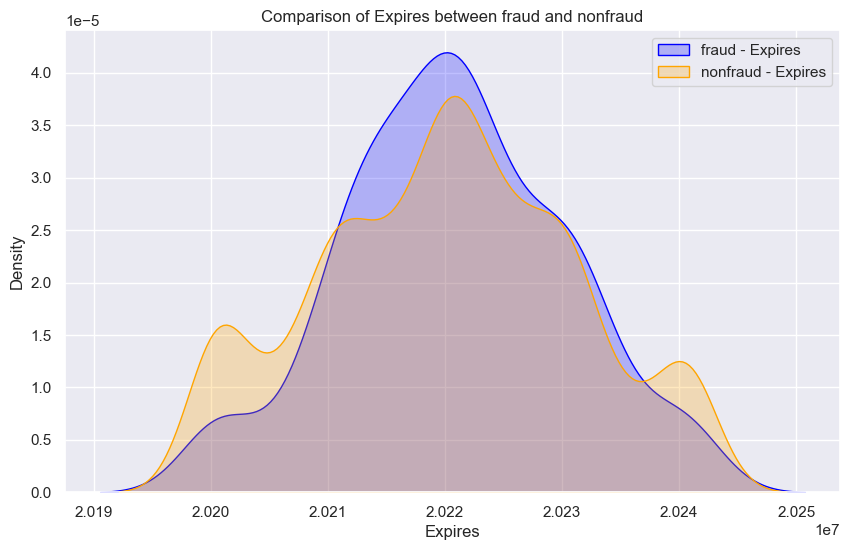

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


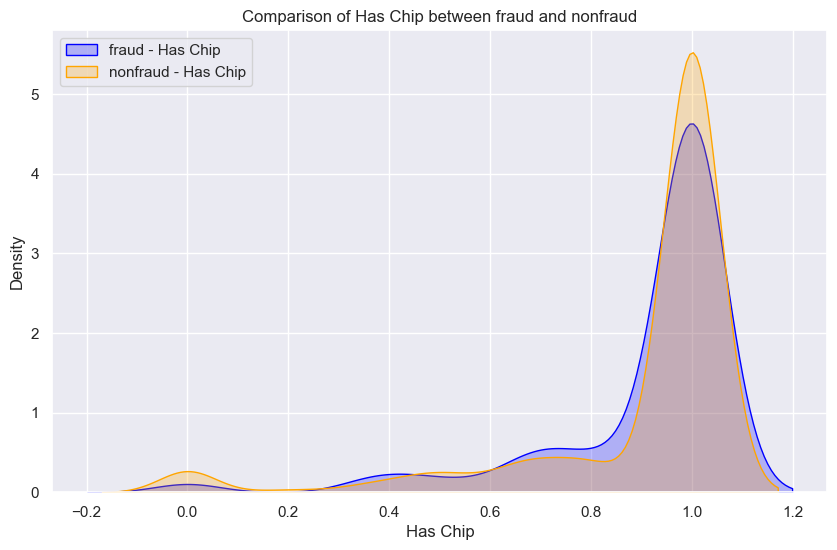

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


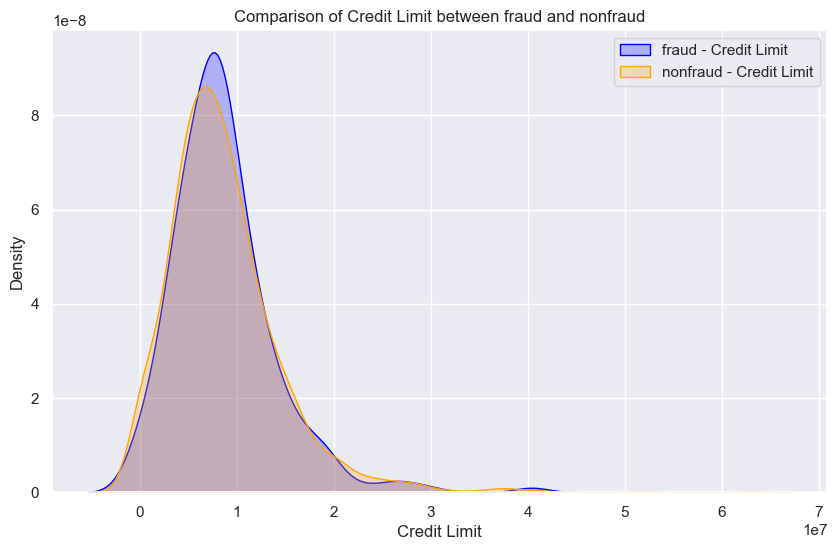

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


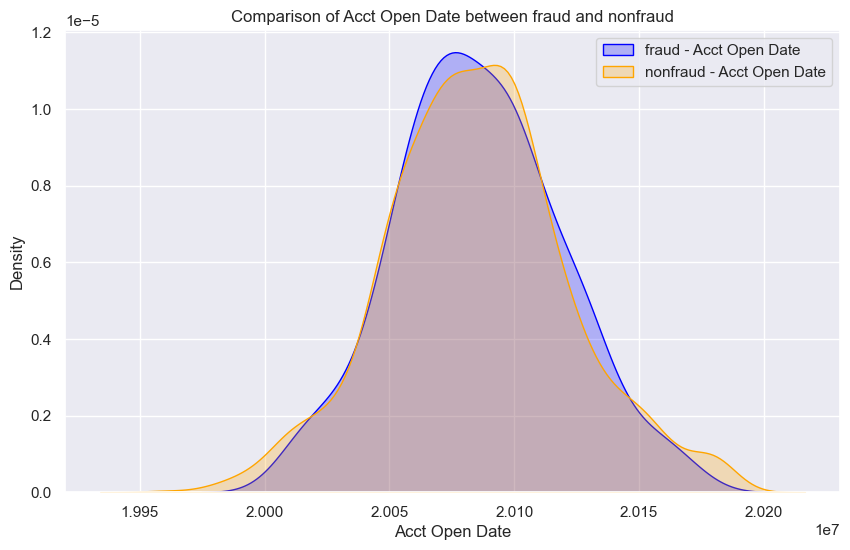

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


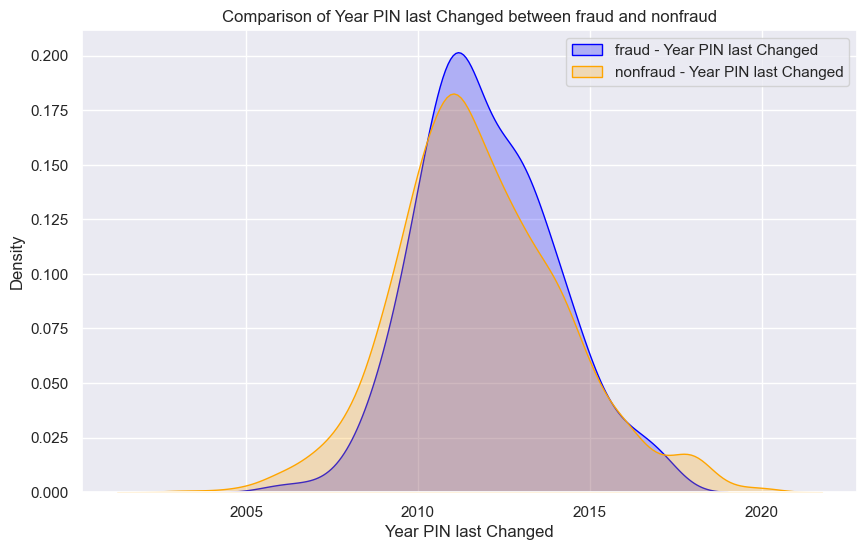

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


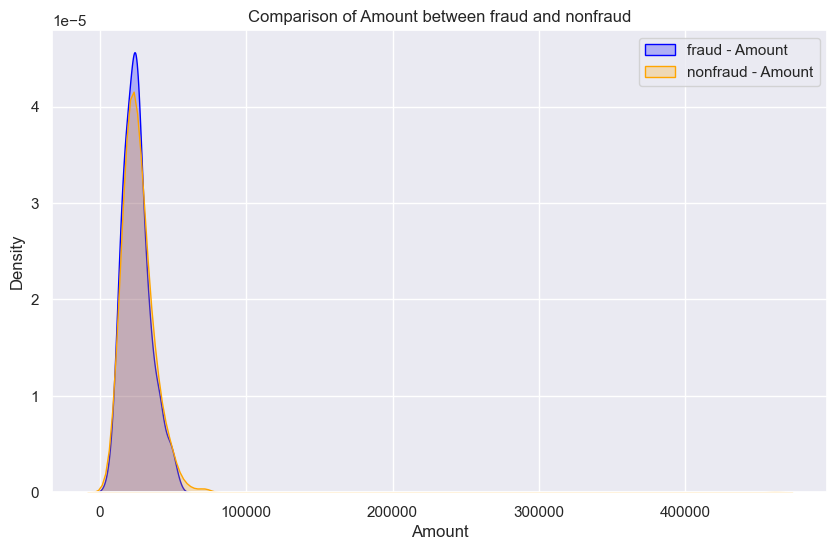

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


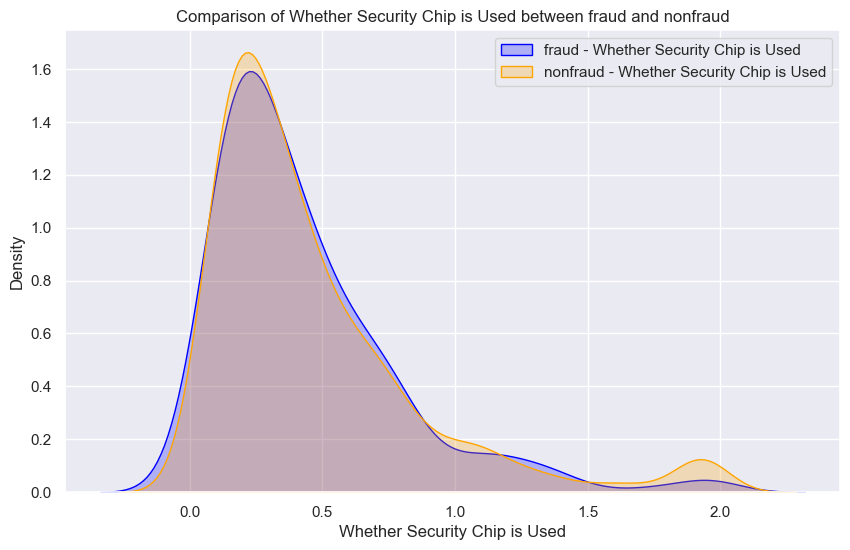

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


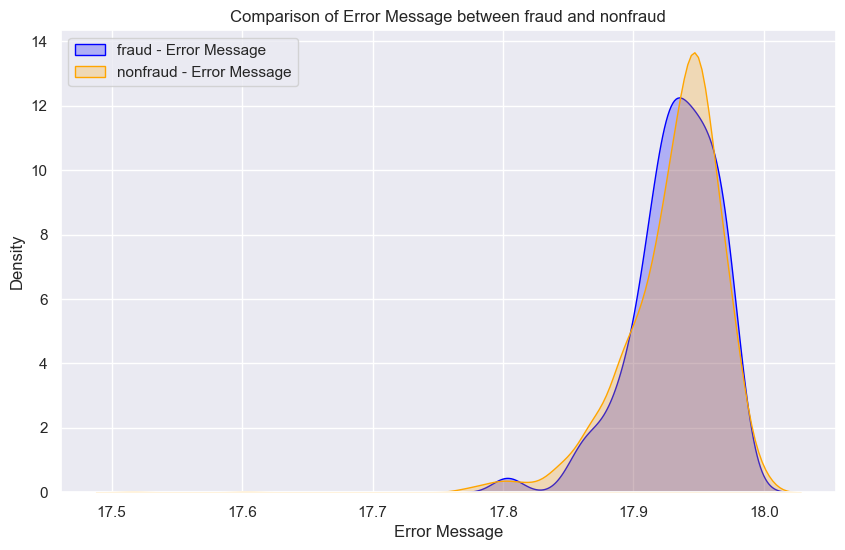

C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')
C:\Users\user\AppData\Local\Temp\ipykernel_28084\3270174391.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')


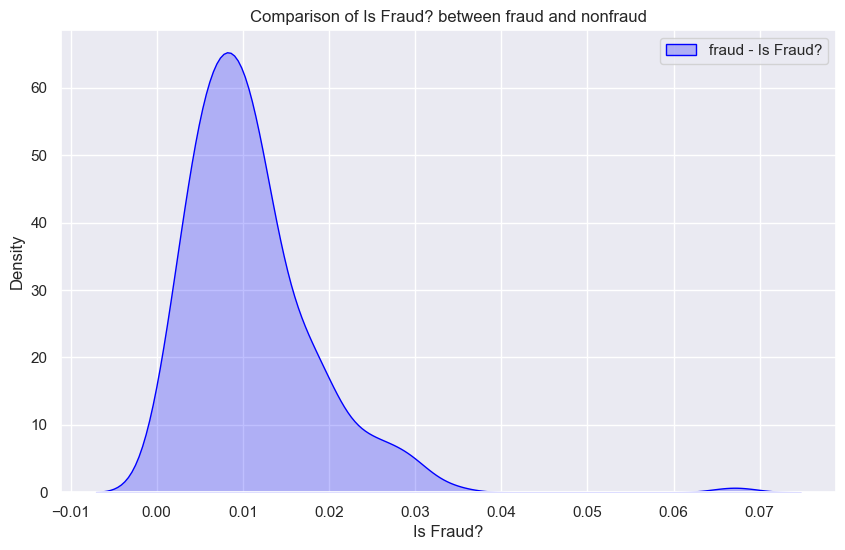

In [27]:
# fraud와 nonfraud 데이터프레임에서 공통된 컬럼을 가져오기
common_columns = fraud.columns.intersection(nonfraud.columns)

# 각 컬럼별로 반복해서 비교하는 플롯 생성
for column in common_columns:
    plt.figure(figsize=(10, 6))
    
    # KDE 플롯으로 컬럼 분포 비교
    sns.kdeplot(fraud[column], label=f'fraud - {column}', shade=True, color='blue')
    sns.kdeplot(nonfraud[column], label=f'nonfraud - {column}', shade=True, color='orange')
    
    plt.title(f'Comparison of {column} between fraud and nonfraud')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


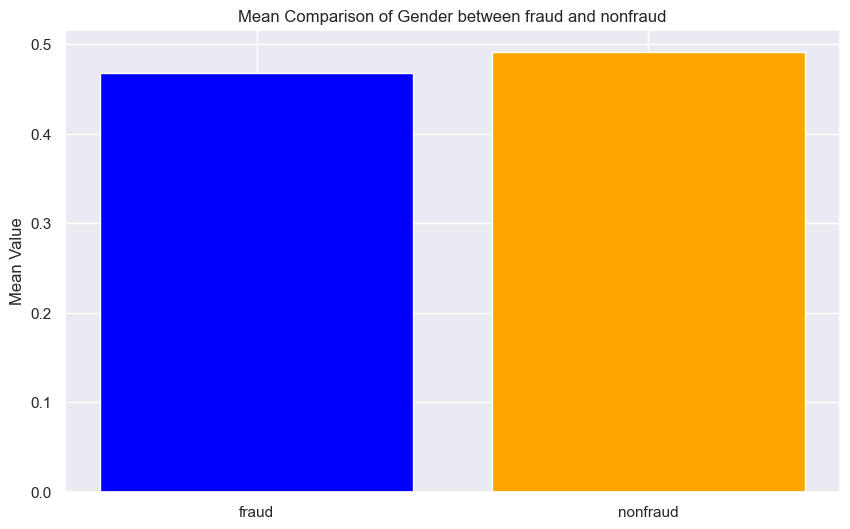

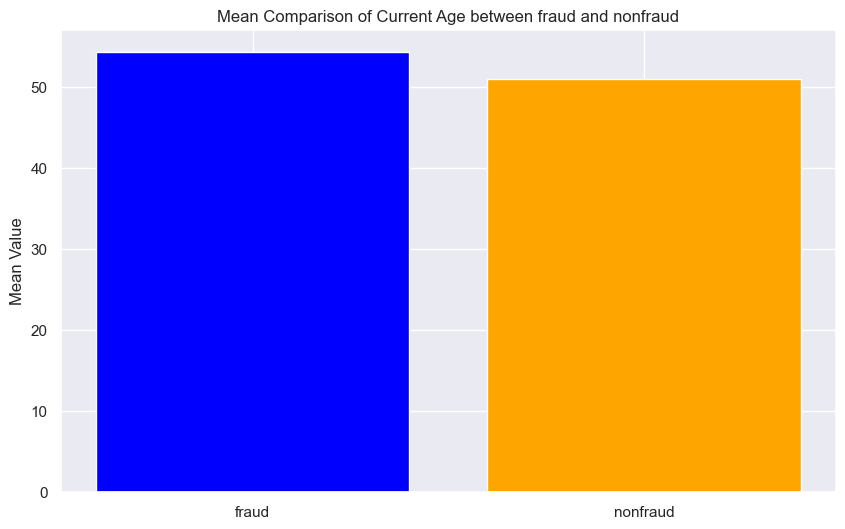

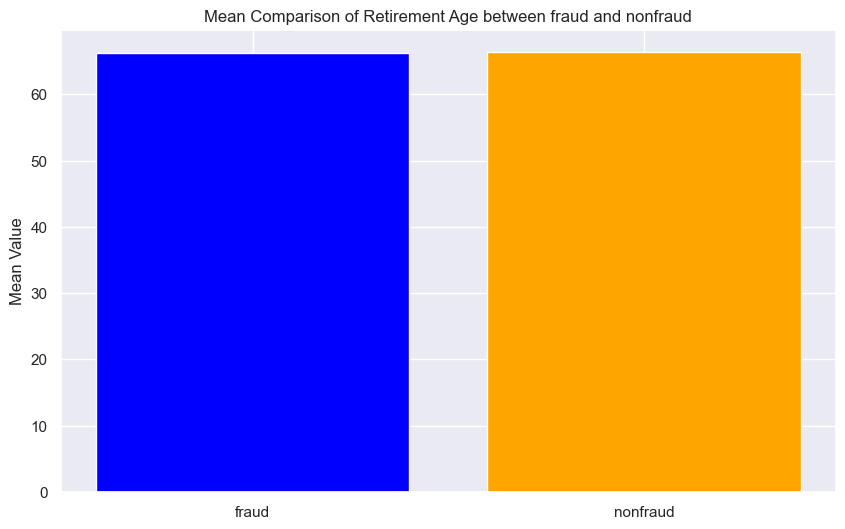

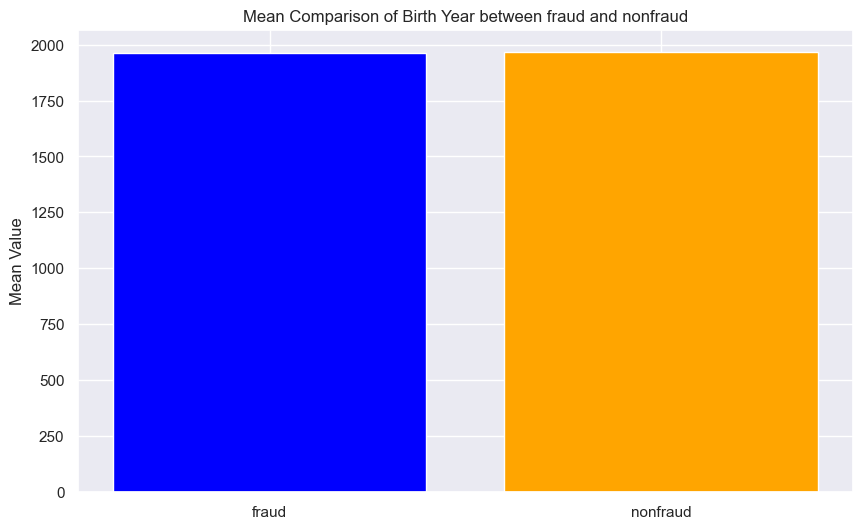

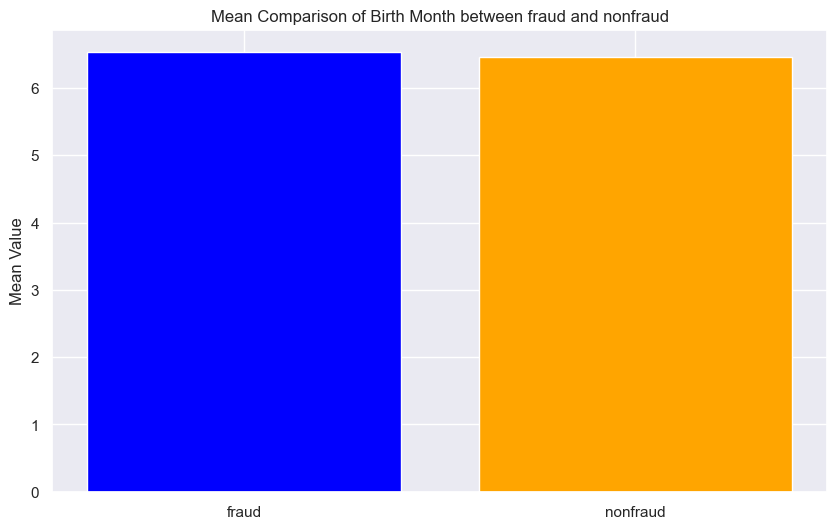

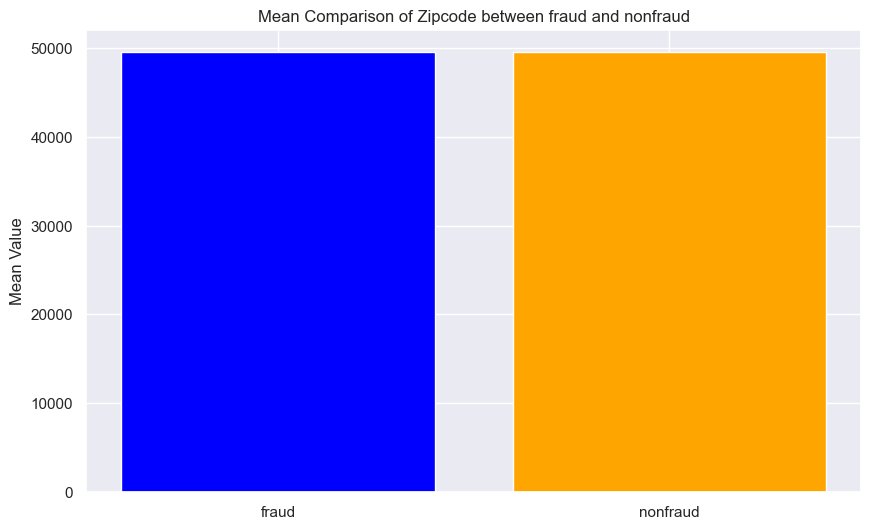

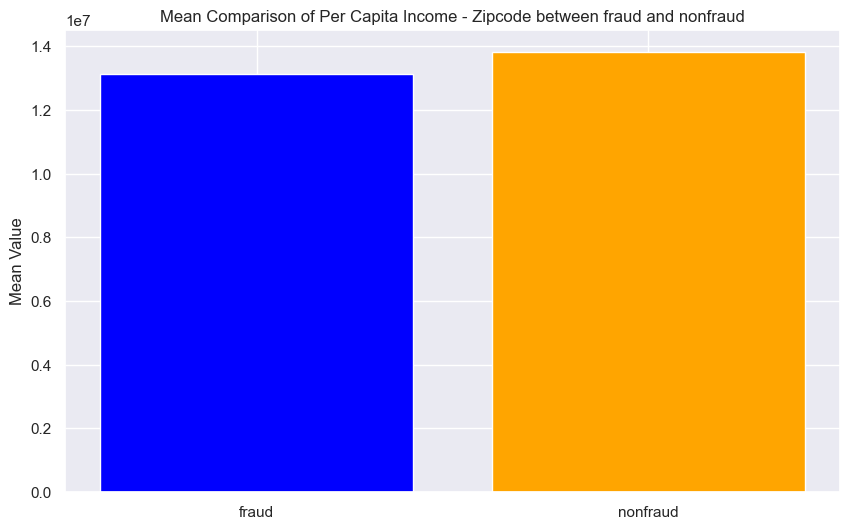

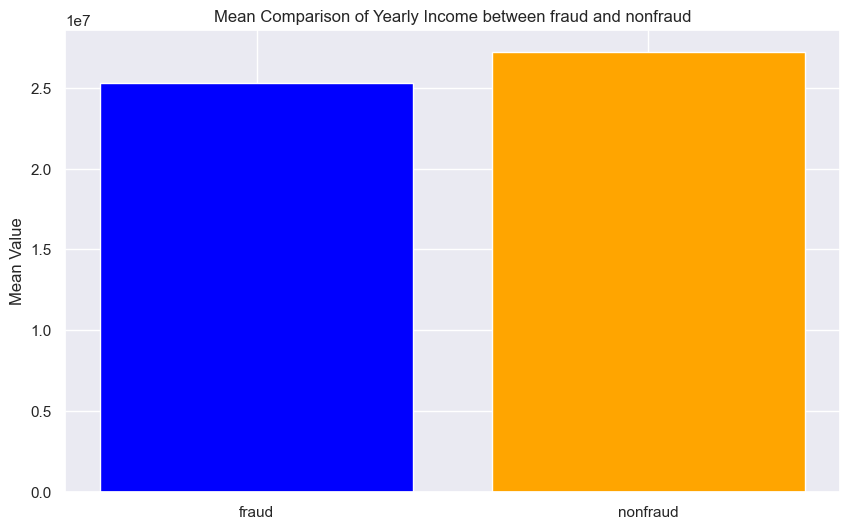

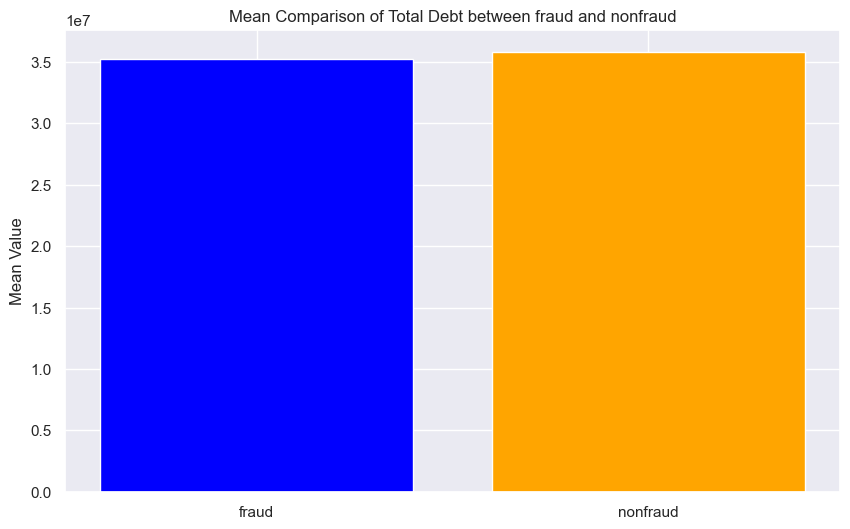

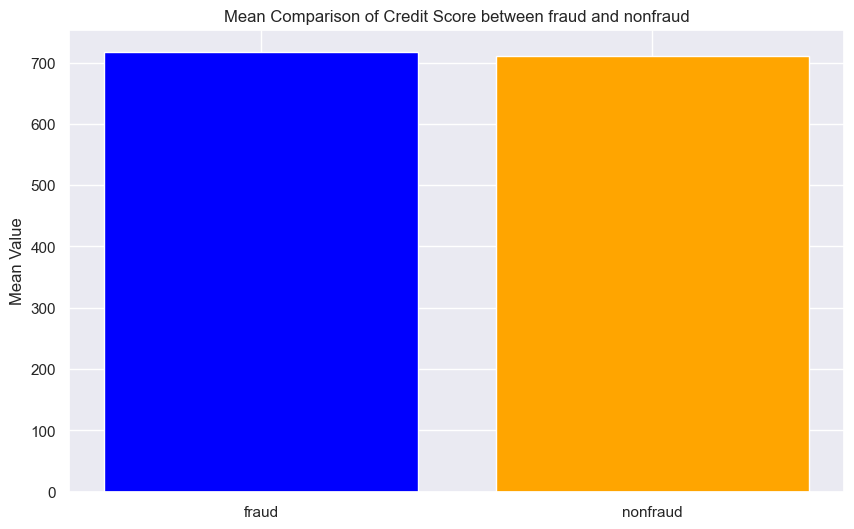

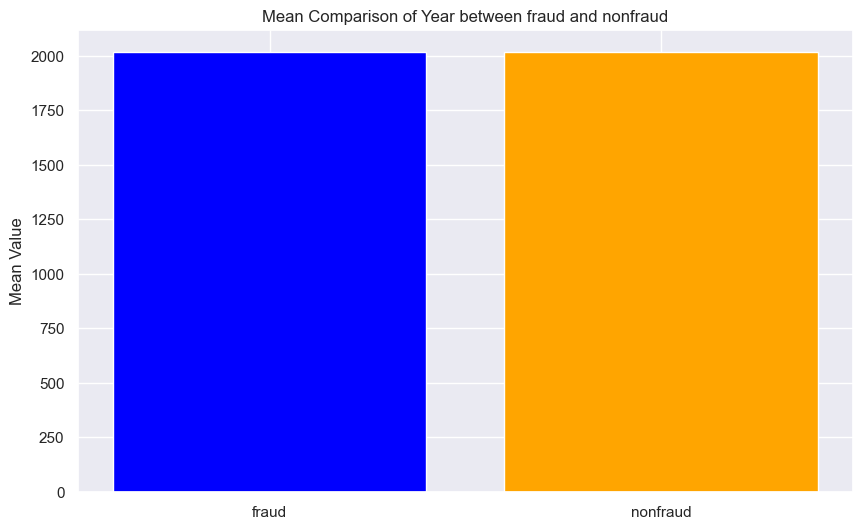

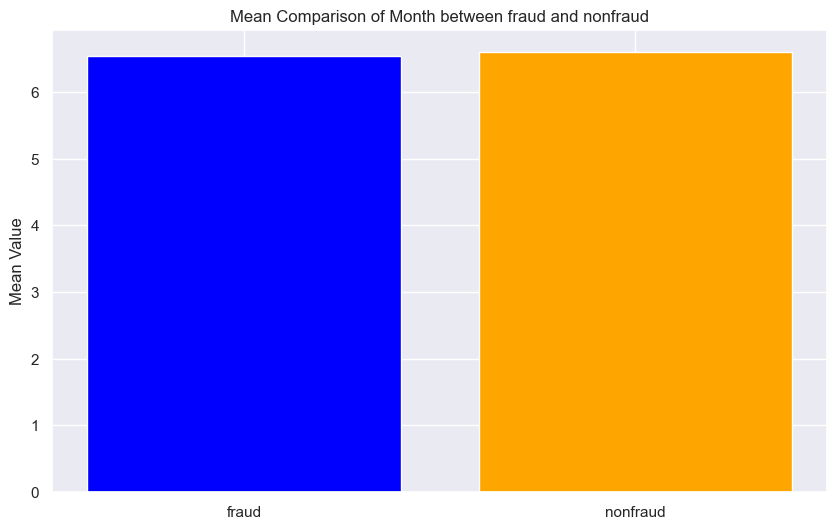

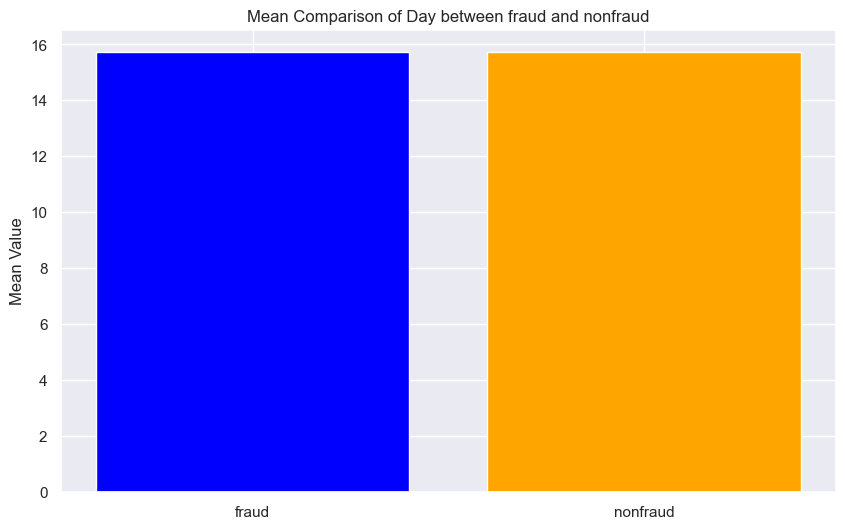

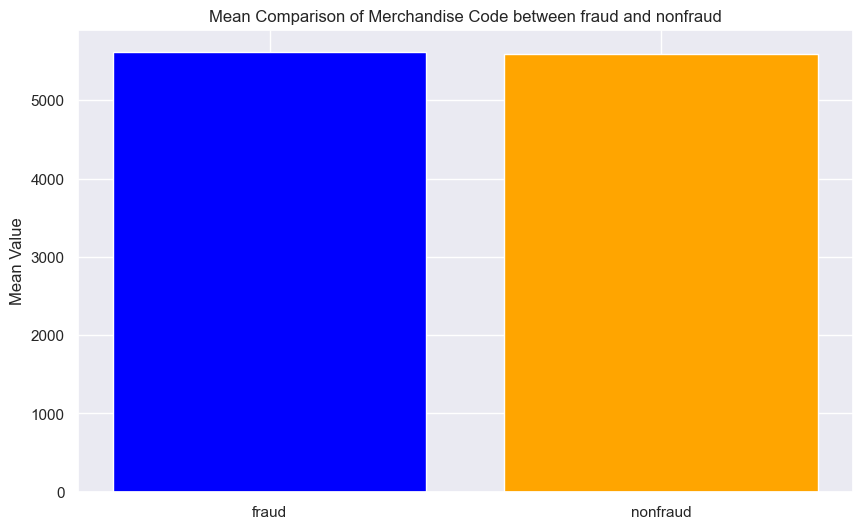

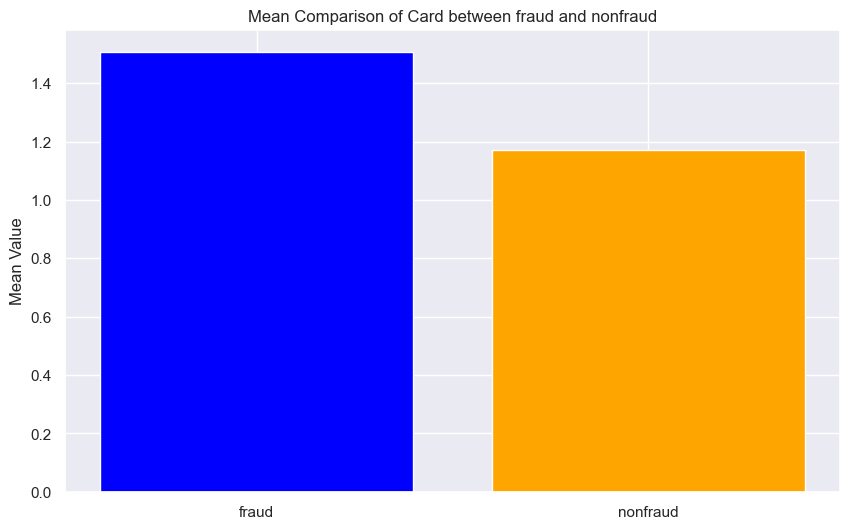

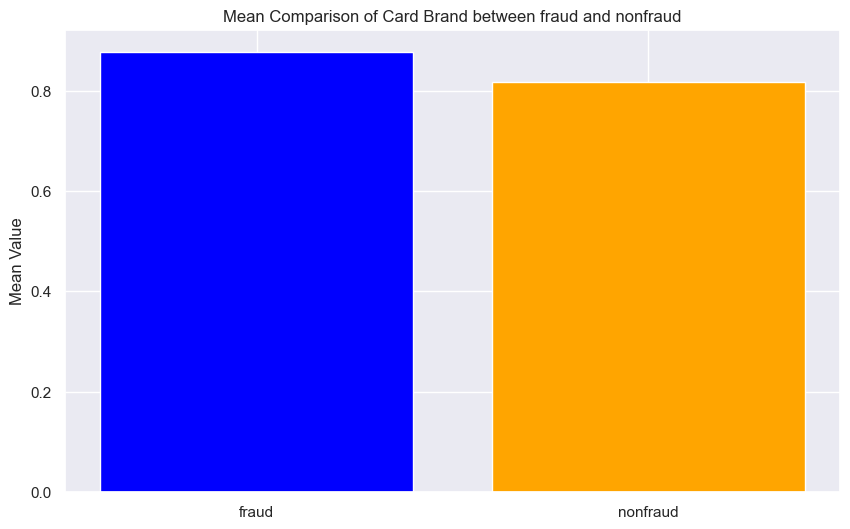

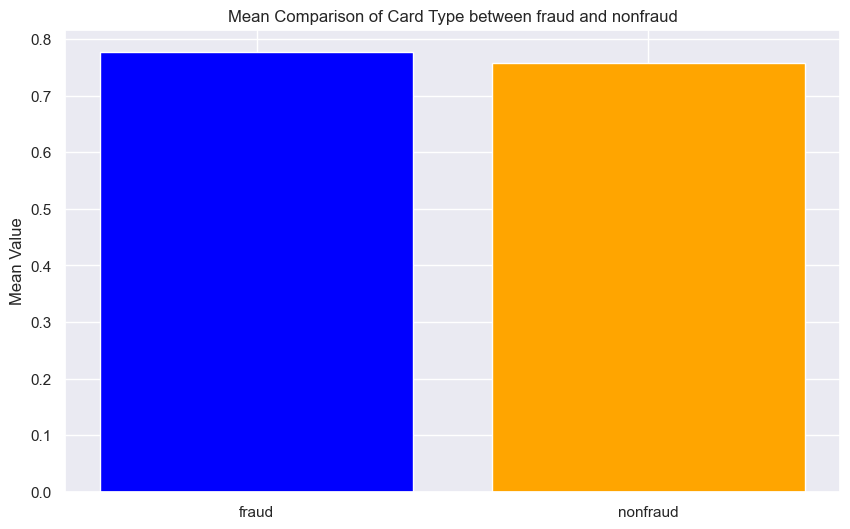

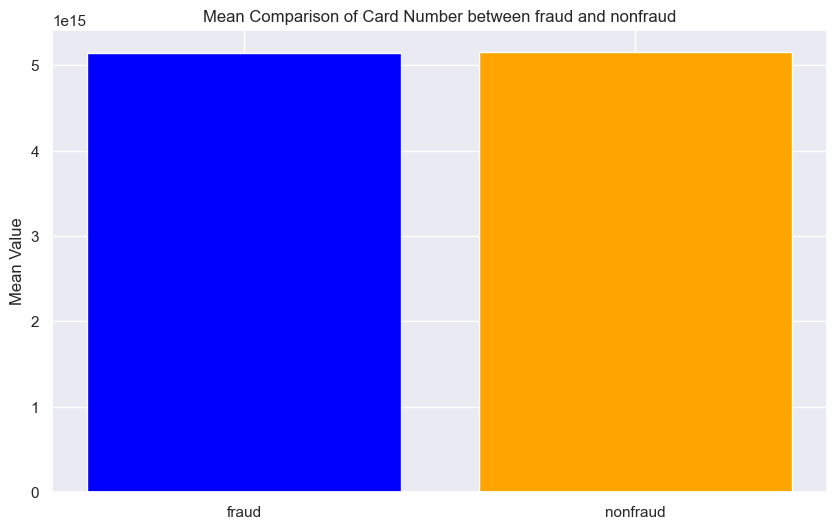

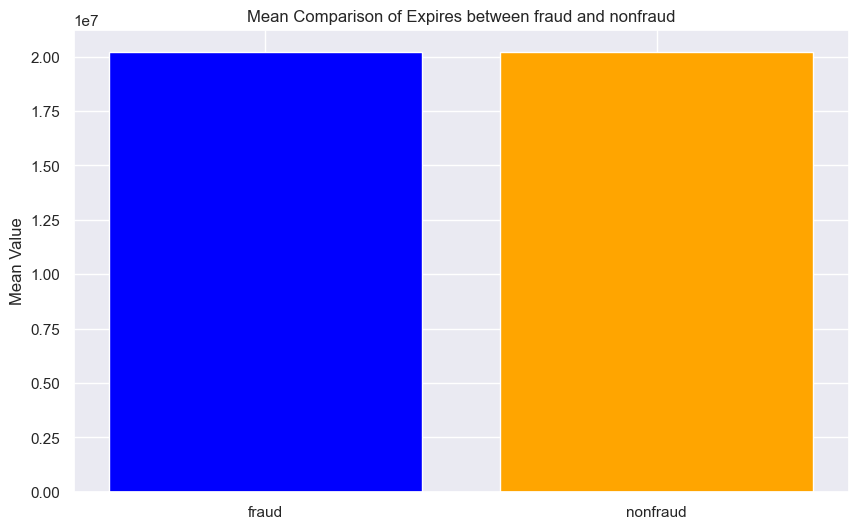

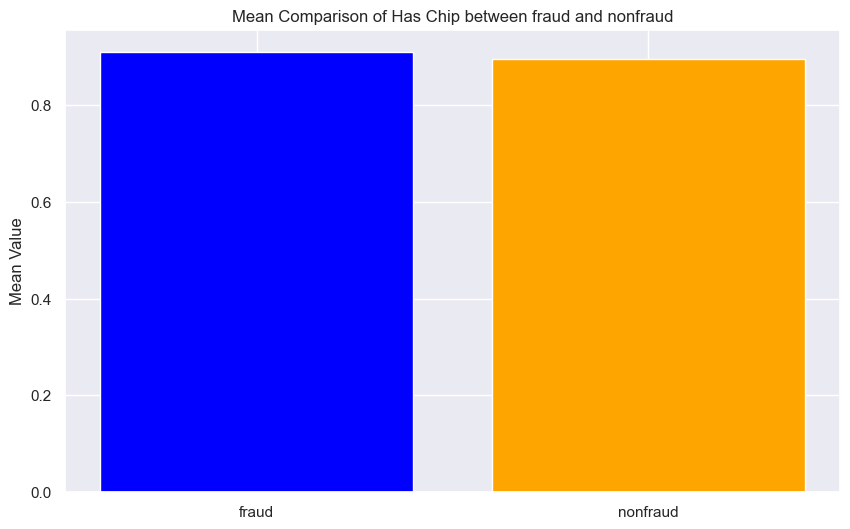

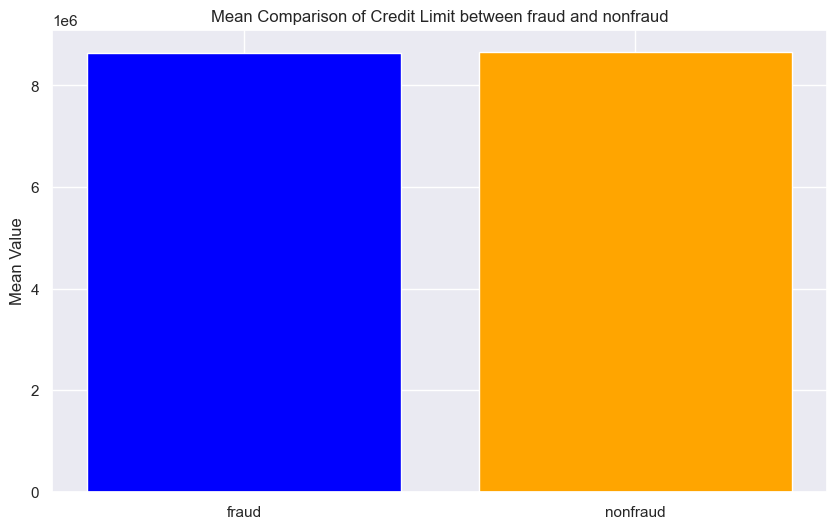

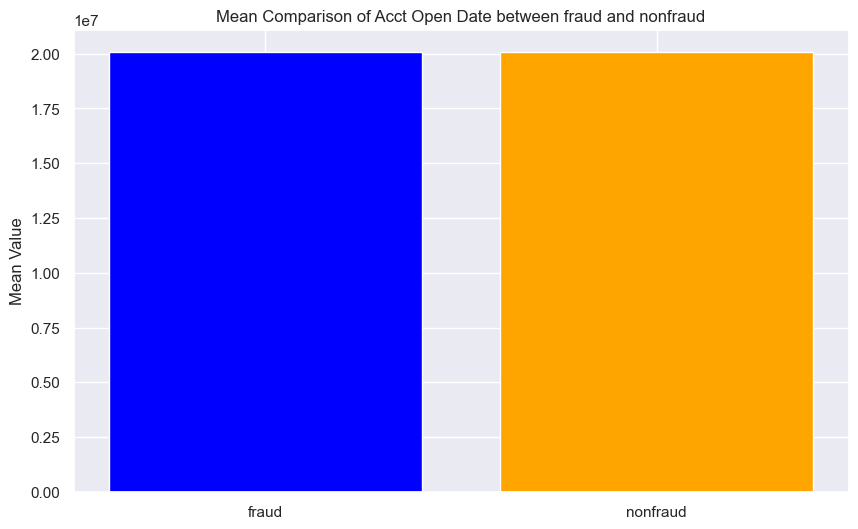

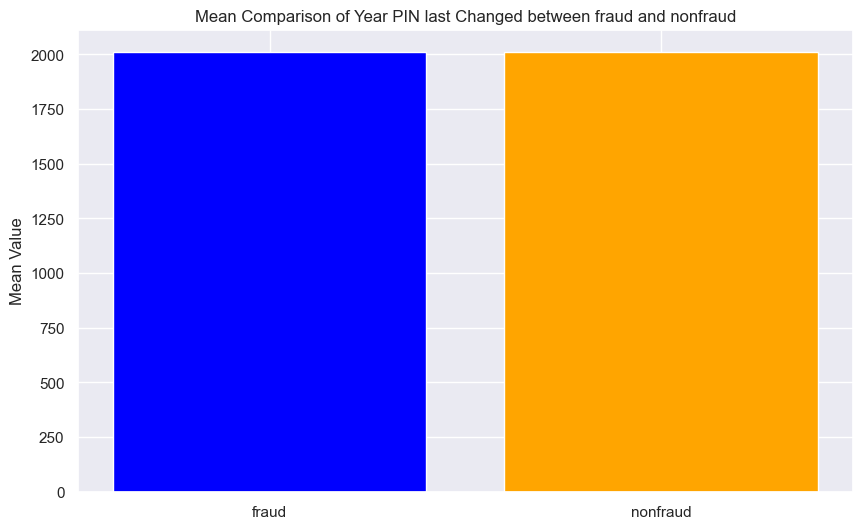

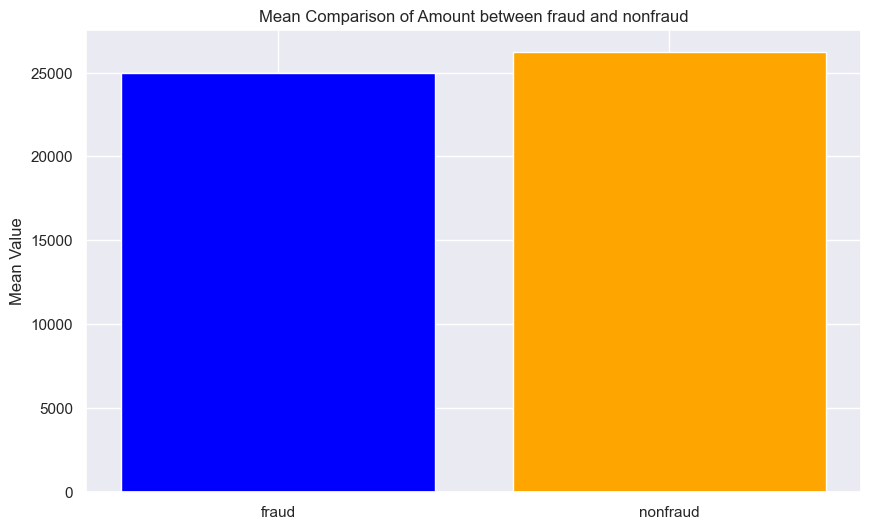

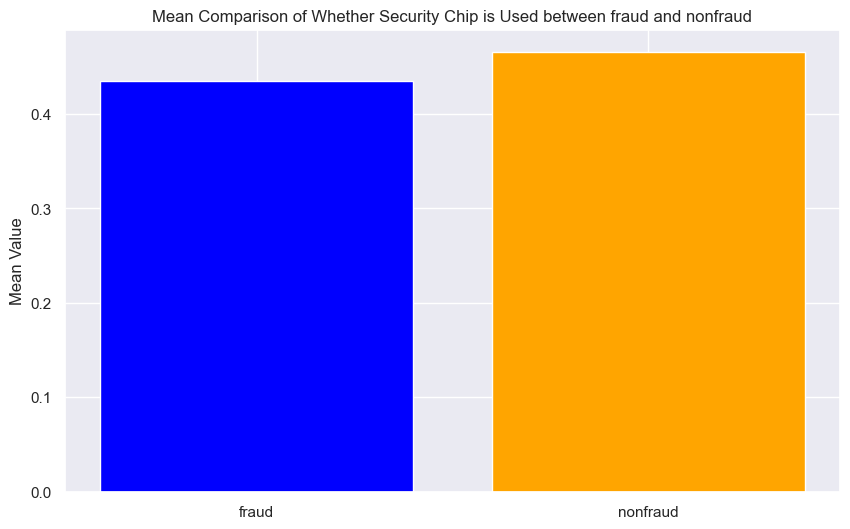

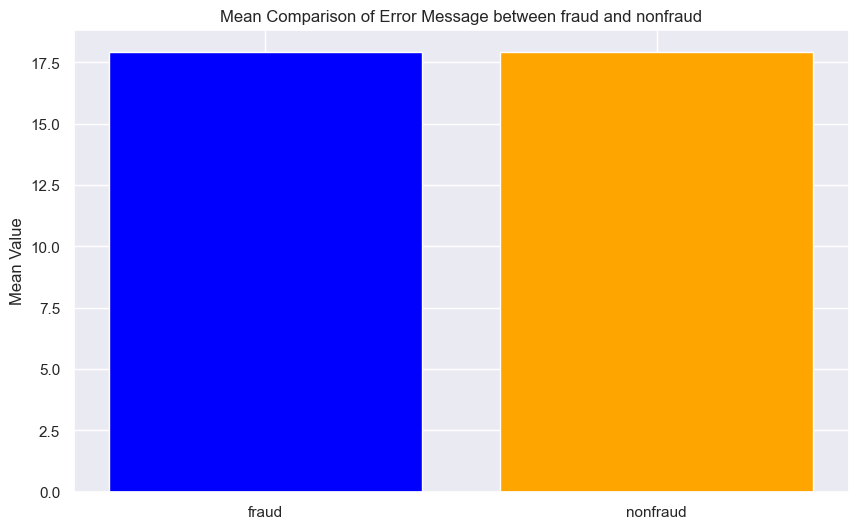

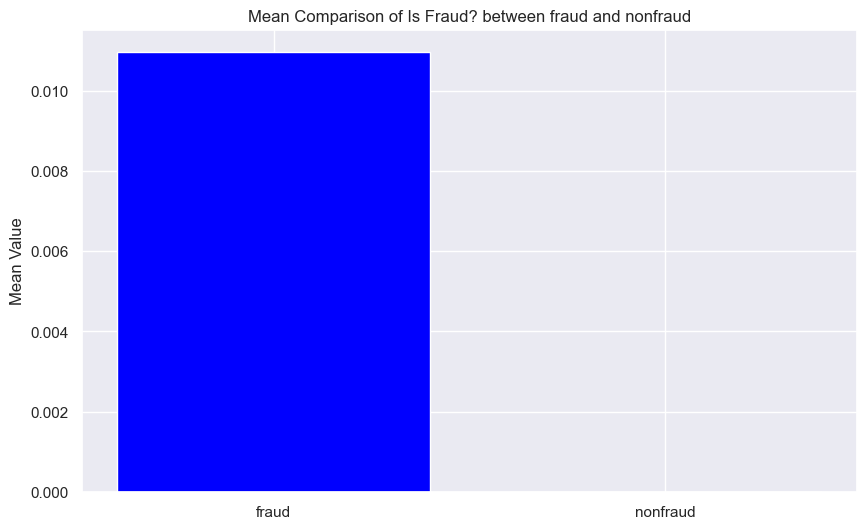

In [28]:
for column in common_columns:
    plt.figure(figsize=(10, 6))

    # fraud와 nonfraud 데이터의 컬럼별 평균 값 계산
    mean_fraud = fraud[column].mean()
    mean_nonfraud = nonfraud[column].mean()

    # 막대그래프 그리기
    plt.bar(['fraud', 'nonfraud'], [mean_fraud, mean_nonfraud], color=['blue', 'orange'])
    
    plt.title(f'Mean Comparison of {column} between fraud and nonfraud')
    plt.ylabel('Mean Value')
    plt.show()


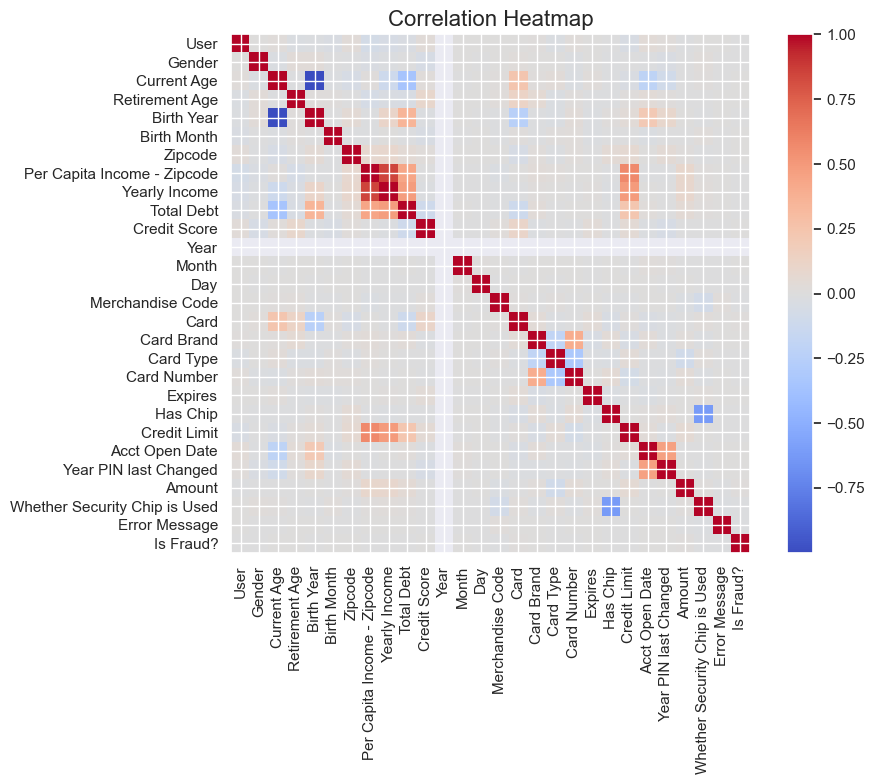

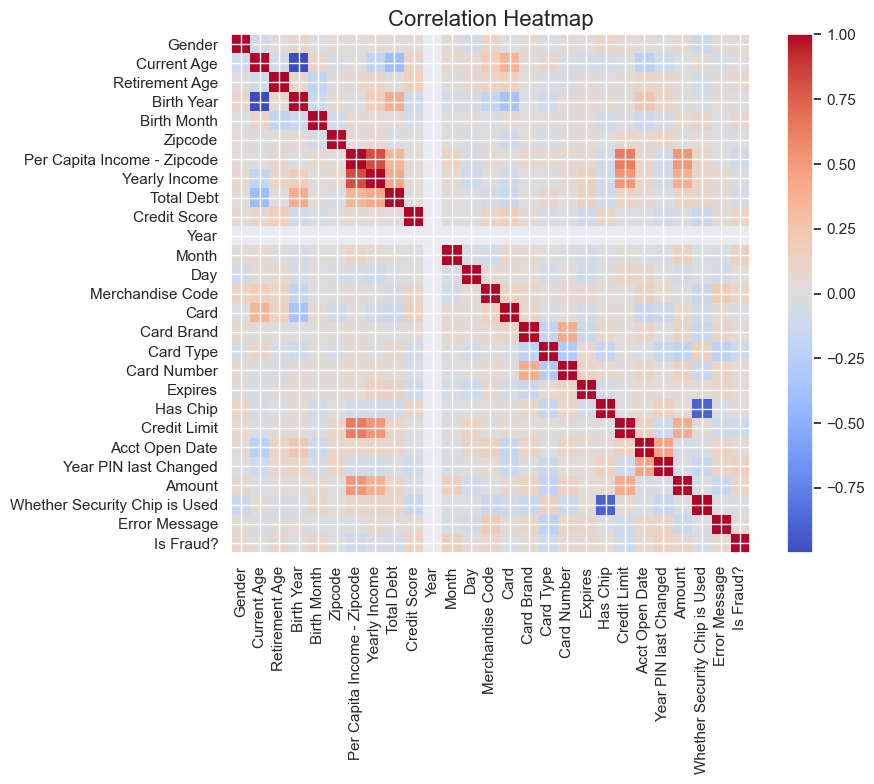

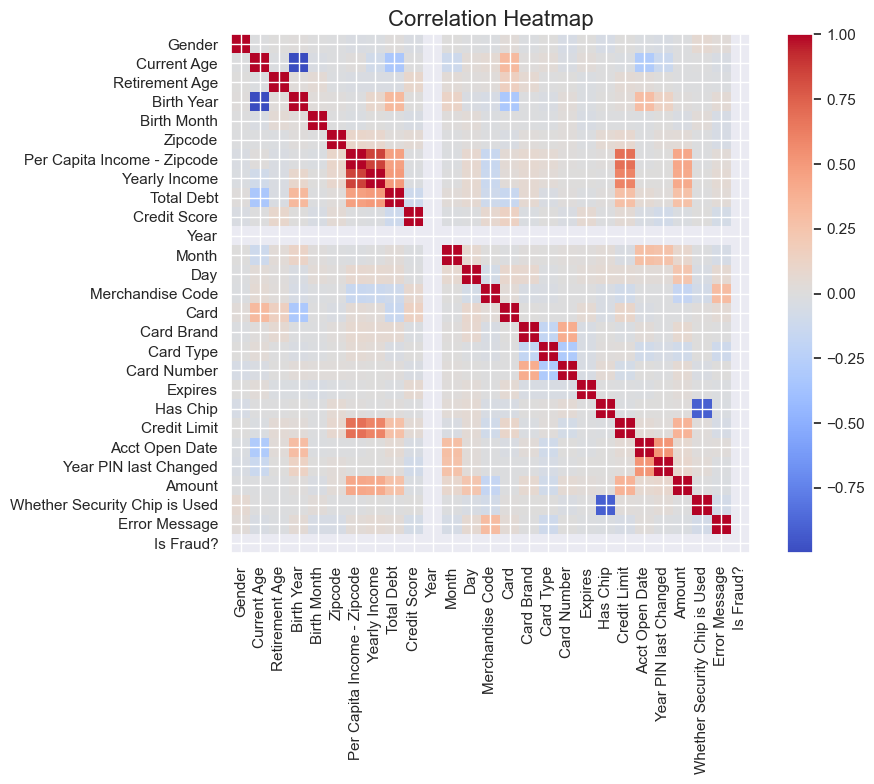

In [29]:
correlation_write(train_data)
correlation_write(fraud,columns=27)
correlation_write(nonfraud,columns=27)

---
---
---
#### 데이터 불러오기

In [30]:
train_data = pd.read_csv('datas/train.csv')
encode_and_transform_dates(train_data)
print(train_data.columns)

Index(['User', 'Gender', 'Current Age', 'Retirement Age', 'Birth Year',
       'Birth Month', 'Zipcode', 'Per Capita Income - Zipcode',
       'Yearly Income', 'Total Debt', 'Credit Score', 'Year', 'Month', 'Day',
       'Merchandise Code', 'Card', 'Card Brand', 'Card Type', 'Card Number',
       'Expires', 'Has Chip', 'Credit Limit', 'Acct Open Date',
       'Year PIN last Changed', 'Amount', 'Whether Security Chip is Used',
       'Error Message', 'Is Fraud?'],
      dtype='object')


#### 파생변수 생성
account open date / credit limit  
account open date / per capital income  
credit score/ user  
security chip used/ has chip  
account pin changed/ security used  
  
credit score/ credit limit  
has chip/ pin last changed  
retirement age/ current age  
yearly income/ debt  

#### Train / Test Dataset 분리하기

In [32]:
selected_columns=['Current Age','Card','Whether Security Chip is Used','Yearly Income','Zipcode','Merchandise Code','Is Fraud?']
td = train_data[selected_columns]

td = td.dropna()

X = td.drop(columns=['Is Fraud?'])
y = td['Is Fraud?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Logistic Regression

Accuracy: 0.6546
              precision    recall  f1-score   support

           0       1.00      0.65      0.79    492727
           1       0.00      0.52      0.00       704

    accuracy                           0.65    493431
   macro avg       0.50      0.59      0.40    493431
weighted avg       1.00      0.65      0.79    493431



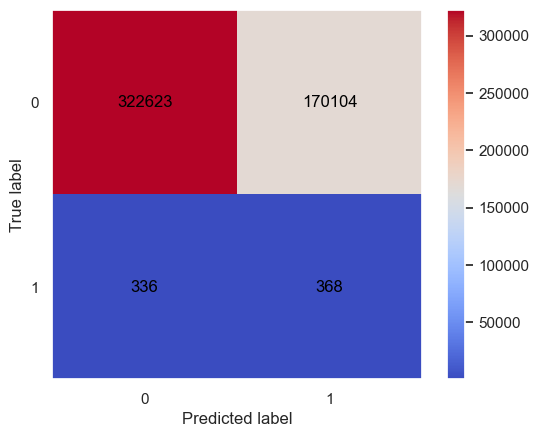

In [33]:

model = LogisticRegression(penalty='l2',fit_intercept=False,class_weight='balanced',max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 분류 리포트 출력 (Precision, Recall, F1-score 등)
print(classification_report(y_test, y_pred))

cm=confusion_matrix(y_test,y_pred)
matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
matrix.plot(cmap='coolwarm')
for text in matrix.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()

### Random Forest

In [34]:
rf=RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.9904
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    492727
           1       0.06      0.40      0.11       704

    accuracy                           0.99    493431
   macro avg       0.53      0.69      0.55    493431
weighted avg       1.00      0.99      0.99    493431



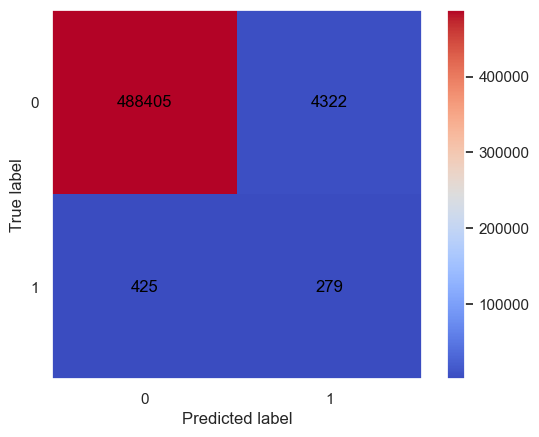

In [35]:
rf_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, rf_pred)
print(f'Accuracy: {accuracy:.4f}')

# 분류 리포트 출력 (Precision, Recall, F1-score 등)
print(classification_report(y_test, rf_pred))

cm=confusion_matrix(y_test,rf_pred)
matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
matrix.plot(cmap='coolwarm')
for text in matrix.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()

In [36]:
#Random Forest 결과물 -> Feature Importance

importances = rf.feature_importances_
# 특성 이름과 중요도를 함께 보기 (X_train이 DataFrame일 때)
feature_names = X_train.columns  # X_train이 Pandas DataFrame일 때
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도가 높은 순서대로 정렬
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                         Feature  Importance
5               Merchandise Code    0.310985
3                  Yearly Income    0.213173
4                        Zipcode    0.198292
0                    Current Age    0.170376
1                           Card    0.062388
2  Whether Security Chip is Used    0.044787


#### SVM(Support Vector Machine)

Accuracy: 0.5803
              precision    recall  f1-score   support

           0       1.00      0.58      0.73    492727
           1       0.00      0.63      0.00       704

    accuracy                           0.58    493431
   macro avg       0.50      0.61      0.37    493431
weighted avg       1.00      0.58      0.73    493431



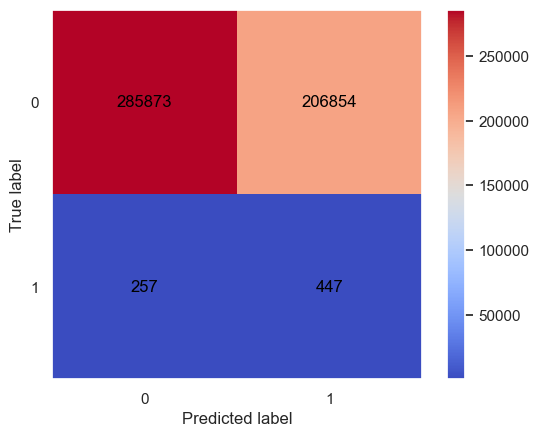

In [37]:
scaler = StandardScaler()
svm = make_pipeline(StandardScaler(),LinearSVC(penalty='l1',class_weight='balanced'))
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# 분류 리포트 출력 (Precision, Recall, F1-score 등)
print(classification_report(y_test, y_pred))

cm=confusion_matrix(y_test,y_pred)
matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
matrix.plot(cmap='coolwarm')
for text in matrix.text_.ravel():
    text.set_color("black")
plt.grid(False)
plt.show()